In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
# load data
mfp = '/home/ngrav/project/wearables/model_zoo'
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')

split = 'train'

X, md_model, trainer = weardtw.data_from_trainer(bst_trainer, split=split)

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split=split,
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [3]:
import functools
import operator
import torch
from torch.autograd import grad
import numpy as np
from tqdm import *

def gather_nd(params, indices):
    """
    Args:
        params: Tensor to index
        indices: k-dimension tensor of integers. 
    Returns:
        output: 1-dimensional tensor of elements of ``params``, where
            output[i] = params[i][indices[i]]
            
            params   indices   output
            1 2       1 1       4
            3 4       2 0 ----> 5
            5 6       0 0       1
    """
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1

    for i in range(ndim)[::-1]:
        idx += indices[i]*m
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)

class PathExplainerTorch(object):
    def __init__(self, model):
        self.model = model
        return
    
    def _get_ref_tensor(self,baseline,batch_size,num_samples):
        number_to_draw = num_samples * batch_size
        replace = baseline.shape[0] < number_to_draw
        sample_indices = np.random.choice(baseline.shape[0],
                                          size=number_to_draw,
                                          replace=replace)
        ref_tensor = baseline[sample_indices,:]
        
        return ref_tensor

    def _get_samples_input(self, input_tensor, baseline, 
                           num_samples, use_expectation):
        '''
        calculate interpolation points
        Args:
            input_tensor: Tensor of shape (batch, ...), where ... indicates
                          the input dimensions. 
            reference_tensor: A tensor of shape (batch, k, ...) where ... 
                indicates dimensions, and k represents the number of background 
                reference samples to draw per input in the batch.
        Returns: 
            samples_input: A tensor of shape (batch, k, ...) with the 
                interpolated points between input and ref.
            samples_delta: A tensor of shape (batch, 1, ...) with the
                difference between input and reference for each sample
        '''
        input_dims = list(input_tensor.size())[1:]
        num_input_dims = len(input_dims)
        batch_size = input_tensor.size()[0]
        
        if use_expectation:
            reference_tensor = self._get_ref_tensor(baseline,batch_size,num_samples)
            shape = reference_tensor.shape
            reference_tensor = reference_tensor.view(
                    batch_size, 
                    num_samples, 
                    *(shape[1:]))
            
            # Grab a [batch_size, k]-sized interpolation sample
            t_tensor = torch.FloatTensor(batch_size, num_samples).uniform_(0,1).to(reference_tensor.device)
            shape = [batch_size, num_samples] + [1] * num_input_dims
            interp_coef = t_tensor.view(*shape)

            # Evaluate the end points
            end_point_ref = (1.0 - interp_coef) * reference_tensor

            input_expand_mult = input_tensor.unsqueeze(1)
            end_point_input = interp_coef * input_expand_mult

            # Affine Combine
            samples_input = end_point_input + end_point_ref
            
        else:
            batch_size = input_tensor.size()[0]
            input_expand = input_tensor.unsqueeze(1)
            reps = np.ones(len(baseline.shape)).astype(int)
            reps[0] = batch_size
            reference_tensor = baseline.repeat(list(reps)).unsqueeze(1)
#             reference_tensor = torch.as_tensor(sampled_baseline).unsqueeze(1).to(baseline.device)
            scaled_inputs = [reference_tensor + (float(i)/(num_samples-1))*(input_expand - reference_tensor) \
                             for i in range(0,num_samples)]
            samples_input = torch.cat(scaled_inputs,dim=1)
        
        samples_delta = self._get_samples_delta(input_tensor, reference_tensor)
        samples_delta = samples_delta.to(samples_input.device)
        
        return samples_input, samples_delta
    
    def _get_samples_delta(self, input_tensor, reference_tensor):
        input_expand_mult = input_tensor.unsqueeze(1)
        sd = input_expand_mult - reference_tensor
        return sd
    
    def _get_grads(self, samples_input, output_indices=None):

        grad_tensor = torch.zeros(samples_input.shape).float().to(samples_input.device)
        
        k_ = samples_input.shape[1]

        for i in range(k_):
            particular_slice = samples_input[:,i]
            batch_output = self.model(particular_slice)
            # should check that users pass in sparse labels
            # Only look at the user-specified label
            if batch_output.size(1) > 1:
                sample_indices = torch.arange(0,batch_output.size(0)).to(samples_input.device)
                indices_tensor = torch.cat([
                        sample_indices.unsqueeze(1), 
                        output_indices.unsqueeze(1)], dim=1)
                batch_output = gather_nd(batch_output, indices_tensor)

            model_grads = grad(
                    outputs=batch_output,
                    inputs=particular_slice,
                    grad_outputs=torch.ones_like(batch_output).to(samples_input.device),
                    create_graph=True)
            grad_tensor[:,i,:] = model_grads[0]
        return grad_tensor
           
    def attributions(self, input_tensor, baseline,
                     num_samples = 50, use_expectation=True, 
                     output_indices=None):
        """
        Calculate either Expected or Integrated Gradients approximation of 
        Aumann-Shapley values for the sample ``input_tensor``.
        Args:
            model (torch.nn.Module): Pytorch neural network model for which the
                output should be explained.
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...).
            output_indices (optional, default=None): For multi-class prediction
        """
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]
        
        dev = input_tensor.device
        baseline = baseline.to(dev)
        
        input_tensor.requires_grad_ = True
        
        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')
            
        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')
        
        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               num_samples, use_expectation)
        grad_tensor = self._get_grads(samples_input, output_indices)
        mult_grads = samples_delta * grad_tensor
        attributions = mult_grads.mean(1)
        
        return attributions
    
    def interactions(self, input_tensor, baseline,
                     num_samples=50, use_expectation=True,
                     output_indices=None, interaction_index=None,
                     verbose=True):
        """
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...)
            num_samples: The number of samples to use when computing the
                         expectation or integral.
            use_expectation: If True, this samples baselines and interpolation
                             constants uniformly at random (expected gradients).
                             If False, then this assumes num_refs=1 in which
                             case it uses the same baseline for all inputs,
                             or num_refs=batch_size, in which case it uses
                             baseline[i] for inputs[i] and takes 100 linearly spaced
                             points between baseline and input (integrated gradients).
            output_indices:  If this is None, then this function returns the
                             attributions for each output class. This is rarely
                             what you want for classification tasks. Pass an
                             integer tensor of shape [batch_size] to
                             index the output output_indices[i] for
                             the input inputs[i].
            interaction_index: Either None or an index into the input. If the latter,
                               will compute the interactions with respect to that
                               feature. This parameter should index into a batch
                               of inputs as inputs[(slice(None) + interaction_index)].
                               For example, if you had images of shape (32, 32, 3)
                               and you wanted interactions with respect
                               to pixel (i, j, c), you should pass
                               interaction_index=[i, j, c].
        
        """
        
        if len(input_tensor.shape) != 2:
            raise ValueError('PyTorch Explainer only supports ' + \
                             'interaction for 2D input tensors!')
        
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]
        
        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')
            
        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')
        
        inner_loop_nsamples = int(round(np.sqrt(num_samples)))
        
        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               inner_loop_nsamples, use_expectation)
        
        if interaction_index is not None:
            interaction_mult_tensor = torch.zeros([input_tensor.size(0), samples_input.size(1), input_tensor.size(1)])
        else:
            interaction_mult_tensor = torch.zeros([input_tensor.size(0), samples_input.size(1), 
                                                   input_tensor.size(1), input_tensor.size(1)])
            
        ig_tensor = torch.zeros(samples_input.shape).float()
        
        loop_num = inner_loop_nsamples
        
        if verbose:
            iterable = tqdm(range(loop_num))
        else:
            iterable = range(loop_num)
        
        for i in iterable:
            
            particular_slice = samples_input[:,i]
            ig_tensor[:,i,:] = self.attributions(particular_slice, baseline,
                                                 num_samples=inner_loop_nsamples, use_expectation=use_expectation,
                                                 output_indices=output_indices)
            
            if interaction_index is not None:
                second_grads = grad(
                        outputs=ig_tensor[:,i,interaction_index],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(ig_tensor[:,i,interaction_index]),
                        create_graph=True)[0].detach()
                interaction_mult_tensor[:,i,:] = second_grads

            else:
                for feature in range(input_tensor.size(1)):
                    second_grads = grad(
                        outputs=ig_tensor[:,i,feature],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(ig_tensor[:,i,feature]),
                        create_graph=True)[0].detach()
                    interaction_mult_tensor[:,i,feature,:] = second_grads

        interaction_mult_tensor = interaction_mult_tensor.to(samples_delta.device)
        if interaction_index is not None:
            interaction_tensor = interaction_mult_tensor * samples_delta
        else:
            interaction_tensor = interaction_mult_tensor * samples_delta.unsqueeze(2)
        interactions = interaction_tensor.mean(1)
        
        return interactions

In [4]:
explainer = PathExplainerTorch(evaluation.trainer.model)

In [5]:
# with open('/home/ngrav/project/wearables/results/errorgrp_dev_v52.pkl', 'rb') as f:
#     error_grps = pickle.load(f)
#     f.close()
    

In [6]:
pfp = '/home/ngrav/project/wearables/results/'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)

In [7]:
# redefine error groups
threshold = 10
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [8]:
md_model = md_model.merge(md.loc[:, [col for col in md.columns if col not in md_model.columns]], 
                          left_index=True, right_index=True, how='left')

In [10]:
error_grps = {}
for g in md_model['Error group'].unique():
    error_grps[g] = md_model.loc[(md_model['Error group'] == g)].index.to_list()

In [11]:
# select error groups 
n_samples = 100

# md_model['High Error Group'] = md_model.index.isin(error_grps['high'])
# md_model['Low Error Group'] = md_model.index.isin(error_grps['low'])
error_grp_sample = {k:list(np.random.choice(error_grps[k], n_samples)) for k in error_grps.keys()}
del error_grp_sample['lt10wks'] # only look at extremes for now
# error_grp_sample = {
#     'High actigraphy-GA': md_model.loc[md_model['High Error Group']].sample(n_samples).index.to_list(),
#     'Low actigraphy-GA': md_model.loc[md_model['Low Error Group']].sample(n_samples).index.to_list()}

In [12]:
def featattr_peruid(X, md, uids, explainer, trainer):
    '''
    Returns:
      df (pd.DataFrame)
      uids (dict): 'groupname': list of unique ids
    '''
    total_t = time.time()
    df = pd.DataFrame()
    counter = 0
    for i, g in enumerate(uids.keys()):
        for uid in uids[g]:
            idx = np.where(md.index==uid)[0].item()
            x = X[idx, :, :].unsqueeze(0)
            x.requires_grad = True
            print('starting idx: {}, unique id: {}\t{:.2f}-min elapsed'.format(idx, uid, (time.time()-total_t)/60))
            if counter==0: # only need to call once
                x_baseline = torch.zeros_like(x)
                x_baseline.requires_grad = True
            attr = explainer.attributions(input_tensor=x,
                                          baseline=x_baseline,
                                          num_samples=20,
                                          use_expectation=True,
                                          output_indices=0)
            dt = pd.DataFrame(attr[0, 0, :].detach().numpy(), columns=['attr'])
            dt['uid'] = uid
            dt['sleep'] = trainer.data.data['data'][uid]['sleep'][:-1].to_numpy()
            dt['group'] = g
            df = df.append(dt)
            counter += 1
    return df

In [71]:
res = featattr_peruid(X, md_model, error_grp_sample, explainer, trainer)

starting idx: 1319, unique id: 1247_4	0.00-min elapsed
starting idx: 600, unique id: 2112_11	0.15-min elapsed
starting idx: 1059, unique id: 1336_5	0.29-min elapsed
starting idx: 1566, unique id: 1527_9	0.42-min elapsed
starting idx: 790, unique id: 1090_3	0.55-min elapsed
starting idx: 450, unique id: 1301_8	0.68-min elapsed
starting idx: 1547, unique id: 1436_6	0.81-min elapsed
starting idx: 1560, unique id: 2350_7	0.94-min elapsed
starting idx: 508, unique id: 2527_8	1.07-min elapsed
starting idx: 1250, unique id: 1594_7	1.20-min elapsed
starting idx: 729, unique id: 1858_7	1.33-min elapsed
starting idx: 1557, unique id: 2396_6	1.46-min elapsed
starting idx: 392, unique id: 1723_9	1.59-min elapsed
starting idx: 1553, unique id: 1408_6	1.72-min elapsed
starting idx: 1130, unique id: 1302_5	1.85-min elapsed
starting idx: 790, unique id: 1090_3	1.98-min elapsed
starting idx: 199, unique id: 2030_8	2.11-min elapsed
starting idx: 1395, unique id: 2437_9	2.24-min elapsed
starting idx: 151

# compare sleep v. wake attribution

In [13]:
from scipy.stats import mannwhitneyu

In [73]:
res.head()

,attr,uid,sleep,group
0,0.000000,1247_4,1,Higher-than-actual
1,0.000000,1247_4,1,Higher-than-actual
2,0.000000,1247_4,1,Higher-than-actual
3,-0.021678,1247_4,1,Higher-than-actual
4,-0.019088,1247_4,0,Higher-than-actual


In [48]:
# res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy().mean() - res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy().mean()

In [137]:
# sleep
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=220566212896.5, pvalue=1.6198736781249616e-50)

In [142]:
np.abs(np.mean(a)) - np.abs(np.mean(b))

0.0001233005

In [ ]:
res['abs_attr'] = res['attr'].abs()

In [171]:
res['abs_attr'].quantile(0.999)

0.38815289673210157

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

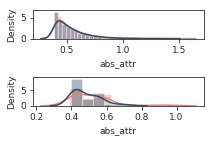

In [ ]:
dt = res.loc[res['abs_attr']>=res['abs_attr'].quantile(0.999)]

fig, ax = plt.subplots(2, 1, figsize=(3,2))
sns.distplot(dt.loc[(dt['sleep']==0) & (dt['group']=='Higher-than-actual'), 'abs_attr'], color='#E57F84', label='Higher-than-actual', ax=ax[0])
sns.distplot(dt.loc[(dt['sleep']==0) & (dt['group']=='Lower-than-actual'), 'abs_attr'], color='#2F5061', label='Lower-than-actual', ax=ax[0])

sns.distplot(dt.loc[(dt['sleep']==1) & (dt['group']=='Higher-than-actual'), 'abs_attr'], color='#E57F84', label='Higher-than-actual', ax=ax[1])
sns.distplot(dt.loc[(dt['sleep']==1) & (dt['group']=='Lower-than-actual'), 'abs_attr'], color='#2F5061', label='Lower-than-actual', ax=ax[1])
fig.tight_layout()

fig.savefig(os.path.join(pfp, 'distplot_wakeVsleep_errgrp_upperthousandth.pdf'))

In [169]:
# sns.distplot(
#     res.loc[((
#     ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
#     ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
#     (res['sleep']==0) & (res['group']=='Higher-than-actual')), 'attr'], color='#333652', label='Higher-than-actual')
# sns.distplot(
#     res.loc[((
#     ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
#     ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
#     (res['sleep']==0) & (res['group']=='Lower-than-actual')), 'attr'], color='#90ADC6', label='Lower-than-actual')

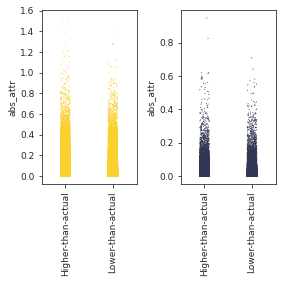

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(4, 4))
sns.stripplot(x='group', y='abs_attr', 
              data=res.loc[((
    ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
    ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
    (res['sleep']==0)), :], 
              hue='sleep', rasterized=True, s=1, ax=ax[0], palette={0:'#FAD02C', 1:'#333652'},
             )
sns.stripplot(x='group', y='abs_attr', 
              data=res.loc[((
    ((res['attr'] >= (1e-12)) & (res['attr']>=0)) | 
    ((res['attr'] <= -(1e-12)) & (res['attr']<0))) & 
    (res['sleep']==1)), :], 
              hue='sleep', rasterized=True, s=1, ax=ax[1], palette={0:'#FAD02C', 1:'#333652'},
             )
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
fig.tight_layout()
fig.savefig(os.path.join(pfp, 'stripplot_featattrVerrorgrp.pdf'))

In [ ]:
n_comparisons = 4
# sleep
a = res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy()
b = res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']==1), 'attr'].to_numpy()

statistic, p = mannwhitneyu(a, b)
p = p*n_comparisons
p

In [82]:
# sleep, groupbed by uid
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=2431.0, pvalue=0.004680970542715164)

In [83]:
# wake
a = res.loc[(res['group']=='Higher-than-actual') & res['sleep']!=1, 'attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & res['sleep']!=1, 'attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=905197214273.5, pvalue=0.0014525912454601264)

In [84]:
# wake, grouped by uid
a = res.loc[(res['group']=='Higher-than-actual') & (res['sleep']!=1), :].groupby('uid').mean()['attr'].to_numpy()
b = res.loc[(res['group']=='Lower-than-actual') & (res['sleep']!=1), :].groupby('uid').mean()['attr'].to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [132]:
# sleep - wake, grouped by uid
a = (res.loc[(res['group']=='Higher-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'] - res.loc[(res['group']=='High actigraphy-GA') & (res['sleep']!=1), :].groupby('uid').mean()['attr']).to_numpy()
b = (res.loc[(res['group']=='Lower-than-actual') & (res['sleep']==1), :].groupby('uid').mean()['attr'] - res.loc[(res['group']=='Low actigraphy-GA') & (res['sleep']!=1), :].groupby('uid').mean()['attr']).to_numpy()

mannwhitneyu(a, b)

MannwhitneyuResult(statistic=342.0, pvalue=1.0541184417863536e-22)

# questions

## association btw importance and time of (...)

time of day: weekend vs. weekday, morning vs. evening, sleep v. wake; day vs. night

In [14]:
def featattr_peruid(X, md, uids, explainer, trainer):
    '''
    Returns:
      df (pd.DataFrame)
      uids (dict): 'groupname': list of unique ids
    '''
    total_t = time.time()
    df = pd.DataFrame()
    counter = 0
    for i, g in enumerate(uids.keys()):
        for uid in uids[g]:
            idx = np.where(md.index==uid)[0].item()
            x = X[idx, :, :].unsqueeze(0)
            x.requires_grad = True
            print('starting idx: {}, unique id: {}\t{:.2f}-min elapsed'.format(idx, uid, (time.time()-total_t)/60))
            
            if counter==0: # only need to call once, unless want to add salt & pepper noise
                x_baseline = torch.zeros_like(x)
                x_baseline.requires_grad = True
                
            attr = explainer.attributions(input_tensor=x,
                                          baseline=x_baseline,
                                          num_samples=20,
                                          use_expectation=True,
                                          output_indices=0)
            dt = pd.DataFrame(attr[0, 0, :].detach().numpy(), columns=['attr'])
            dt['uid'] = uid
            
            # sleep or wake
            dt['sleep'] = trainer.data.data['data'][uid]['sleep'][:-1].to_numpy()
            
            t = trainer.data.data['data'][uid]['t'][:-1]
            dt['t'] = t.to_list() # does this preserve?
            
            # morning or evening
            dt['morningVevening'] = 'NA'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=6)) & (t.apply(lambda x: x.time()) < datetime.time(hour=12))).to_list(),
                   'morningVevening'] = 'Morning'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=18)) & (t.apply(lambda x: x.time()) <= datetime.time(hour=23, minute=59))).to_list(),
                   'morningVevening'] = 'Evening'
            
            # weekday or weekend
            dt['weekdayVweekend'] = 'Weekday'
            dt.loc[((t.apply(lambda x: x.weekday()) == 5) | (t.apply(lambda x: x.weekday()) == 6)).to_list(),
                   'weekdayVweekend'] = 'Weekend'
            
            # daytime, nighttime
            dt['dayVnight'] = 'Night'
            dt.loc[((t.apply(lambda x: x.time()) >= datetime.time(hour=6)) & (t.apply(lambda x: x.time()) < datetime.time(hour=18))).to_list(), 
                   'dayVnight'] = 'Day'
            
            dt['group'] = g
            df = df.append(dt)
            counter += 1
    return df

In [48]:
# sample low error group, then examine globally on them:
n_samples = 100
lt4wk = {'lt4wk': md_model.loc[(md_model['error'].abs() <= 4), :].sample(n_samples, replace=False).index.to_list(),
         'gt4wk': md_model.loc[(md_model['error'].abs() > 4), :].sample(n_samples, replace=False).index.to_list()}

In [52]:
res_lt4wk = featattr_peruid(X, md_model, lt4wk, explainer, trainer)

starting idx: 261, unique id: 1720_16	0.00-min elapsed
starting idx: 1001, unique id: 2565_34	0.14-min elapsed
starting idx: 7, unique id: 2195_16	0.28-min elapsed
starting idx: 1084, unique id: 1662_18	0.42-min elapsed
starting idx: 1641, unique id: 1498_17	0.55-min elapsed
starting idx: 1287, unique id: 1828_26	0.69-min elapsed
starting idx: 1218, unique id: 2332_23	0.83-min elapsed
starting idx: 1097, unique id: 2436_9	0.96-min elapsed
starting idx: 1091, unique id: 2260_26	1.10-min elapsed
starting idx: 72, unique id: 1386_20	1.24-min elapsed
starting idx: 1098, unique id: 2283_23	1.38-min elapsed
starting idx: 168, unique id: 2575_24	1.52-min elapsed
starting idx: 977, unique id: 1332_14	1.66-min elapsed
starting idx: 289, unique id: 2573_34	1.79-min elapsed
starting idx: 1216, unique id: 2581_20	1.93-min elapsed
starting idx: 2, unique id: 2316_22	2.06-min elapsed
starting idx: 67, unique id: 1193_15	2.20-min elapsed
starting idx: 1583, unique id: 2464_26	2.34-min elapsed
startin

In [95]:
# redo error group, keep low error grp
n_samples = 100
error_grps = {}
for g in md_model['Error group'].unique():
    error_grps[g] = md_model.loc[(md_model['Error group'] == g)].index.to_list()
error_grp_sample = {k:list(np.random.choice(error_grps[k], n_samples)) for k in error_grps.keys()}
res = featattr_peruid(X, md_model, error_grp_sample, explainer, trainer)

starting idx: 1098, unique id: 2283_23	0.00-min elapsed
starting idx: 1332, unique id: 1017_16	0.18-min elapsed
starting idx: 1669, unique id: 1651_16	0.35-min elapsed
starting idx: 1296, unique id: 1108_10	0.49-min elapsed
starting idx: 946, unique id: 2300_34	0.62-min elapsed
starting idx: 1055, unique id: 2129_17	0.76-min elapsed
starting idx: 1647, unique id: 2216_32	0.89-min elapsed
starting idx: 784, unique id: 1344_20	1.02-min elapsed
starting idx: 507, unique id: 1350_15	1.16-min elapsed
starting idx: 744, unique id: 1008_4	1.30-min elapsed
starting idx: 631, unique id: 1310_32	1.42-min elapsed
starting idx: 576, unique id: 2360_23	1.55-min elapsed
starting idx: 681, unique id: 2180_26	1.69-min elapsed
starting idx: 988, unique id: 1438_10	1.83-min elapsed
starting idx: 519, unique id: 2235_13	1.96-min elapsed
starting idx: 1659, unique id: 1667_7	2.09-min elapsed
starting idx: 729, unique id: 1048_6	2.22-min elapsed
starting idx: 461, unique id: 1061_14	2.36-min elapsed
starti

In [96]:
errgrp_ptb = {}
for g1 in ['Higher-than-actual', 'Lower-than-actual']:
    for g2 in [0, 1]:
        errgrp_ptb['{}_ptb{}'.format(g1, g2)] = md_model.loc[(md_model['Error group']==g1) & (md_model['ptb_37wks']==g2), :].index.to_list()
errgrp_ptb_sample = {k:list(np.random.choice(errgrp_ptb[k], n_samples)) for k in errgrp_ptb.keys()}
res_errgrp_ptb = featattr_peruid(X, md_model, errgrp_ptb_sample, explainer, trainer)

starting idx: 140, unique id: 2322_9	0.00-min elapsed
starting idx: 403, unique id: 2573_6	0.13-min elapsed
starting idx: 700, unique id: 1167_8	0.27-min elapsed
starting idx: 1541, unique id: 2221_7	0.41-min elapsed
starting idx: 830, unique id: 1552_9	0.54-min elapsed
starting idx: 1444, unique id: 2070_8	0.67-min elapsed
starting idx: 1337, unique id: 2251_8	0.80-min elapsed
starting idx: 357, unique id: 2481_8	0.94-min elapsed
starting idx: 1012, unique id: 1404_5	1.07-min elapsed
starting idx: 498, unique id: 2617_8	1.20-min elapsed
starting idx: 937, unique id: 1140_4	1.34-min elapsed
starting idx: 225, unique id: 1199_4	1.47-min elapsed
starting idx: 1034, unique id: 1557_10	1.60-min elapsed
starting idx: 1388, unique id: 2285_12	1.73-min elapsed
starting idx: 939, unique id: 1433_9	1.87-min elapsed
starting idx: 1236, unique id: 1188_4	2.00-min elapsed
starting idx: 1721, unique id: 1689_6	2.13-min elapsed
starting idx: 1233, unique id: 1434_6	2.27-min elapsed
starting idx: 133

In [97]:
# interim save, due to time-consuming process
fname = 'featattr_res_220228.pkl'
results_all = {'res_4wk': res_lt4wk, 'res_err_grps': res, 'res_errgrp_ptb': res_errgrp_ptb}
with open(os.path.join(pfp, fname), 'wb') as f:
    pickle.dump(results_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [98]:
!mail -s "results_saved" ngravindra@gmail.com <<< "dumpy batch"

In [54]:
res_lt4wk.head()

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group
0,0.0,1720_16,1,2019-02-28 00:00:00,NA,Weekday,Night,lt4wk
1,0.0,1720_16,1,2019-02-28 00:01:00,NA,Weekday,Night,lt4wk
2,0.0,1720_16,1,2019-02-28 00:02:00,NA,Weekday,Night,lt4wk
3,0.0,1720_16,1,2019-02-28 00:03:00,NA,Weekday,Night,lt4wk
4,0.0,1720_16,1,2019-02-28 00:04:00,NA,Weekday,Night,lt4wk


In [55]:
res_lt4wk.group.unique()

array(['lt4wk', 'gt4wk'], dtype=object)

In [58]:
sleep_cmap = {0:'#FAD02C', 1:'#333652'}
res_lt4wk['abs_attr'] = res_lt4wk['attr'].abs()

In [73]:
def imp_panel(df, grp, out_file=None):
    fig = plt.figure(figsize=(13.5,4))
    for i, g in enumerate(['morningVevening', 'weekdayVweekend', 'dayVnight']):
        ax = fig.add_subplot(1, 4, i+1)
        sns.stripplot(x=g, y='abs_attr', 
                      data=df.loc[(df[g]!='NA') & (df['group']==grp)] if g=='morningVevening' else df.loc[df['group']==grp, :], 
                      s=1, 
                      rasterized=True, 
                      hue='sleep', 
                      dodge=True, 
                      palette=sleep_cmap,
                      ax=ax,
                      zorder=0,)
    #     sns.boxplot(x=g, y='attr', 
    #                 data=res_lt2wk.loc[res_lt2wk[g]!='NA'] if g=='morningVevening' else res_lt2wk,
    #                 boxprops={'facecolor':'none', 'edgecolor':'gray'},
    #                 linewidth=2,
    #                 hue='sleep',
    #                 showfliers=False,
    #                 dodge=True,
    #                 palette=sleep_cmap,
    #                 zorder=1)
        sns.barplot(x=g, y='abs_attr', 
                    data=df.loc[(df[g]!='NA') & (df['group']==grp)] if g=='morningVevening' else df.loc[df['group']==grp, :],
                    facecolor='none', edgecolor='gray',
                    errwidth=2,
                    errcolor='gray',
                    linewidth=2,
                    hue='sleep',
                    dodge=True,
                    ci='sd',
                    palette=sleep_cmap,
                    zorder=1)
        ax.legend().set_visible(False)
        ax.set_xlabel('')
        ax.set_ylabel('Feature importance')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax = fig.add_subplot(1, 4, 4)
    sns.stripplot(x='sleep', y='abs_attr', 
                      data=df.loc[df['group']==grp, :], 
                      s=1, 
                      rasterized=True, 
                      hue='sleep', 
                      dodge=False, 
                      palette=sleep_cmap,
                      ax=ax,
                      zorder=0,)
    sns.barplot(x='sleep', y='abs_attr', 
                data=df.loc[df['group']==grp, :],
                facecolor='none', edgecolor='gray',
                errwidth=2,
                errcolor='gray',
                linewidth=2,
                hue='sleep',
                ci='sd',
                dodge=False,
                palette=sleep_cmap,
                zorder=1)
    ax.legend().set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('Feature importance')

    fig.tight_layout()
    
    if out_file is not None:
        fig.savefig(out_file, bbox_inches='tight', dpi=600)

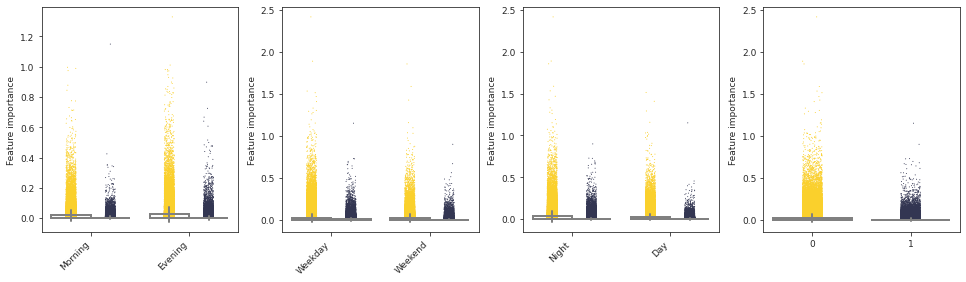

In [74]:
imp_panel(res_lt4wk, 'lt4wk', out_file=os.path.join(pfp, 'stripplots_feature_imp_V_tod.pdf'))


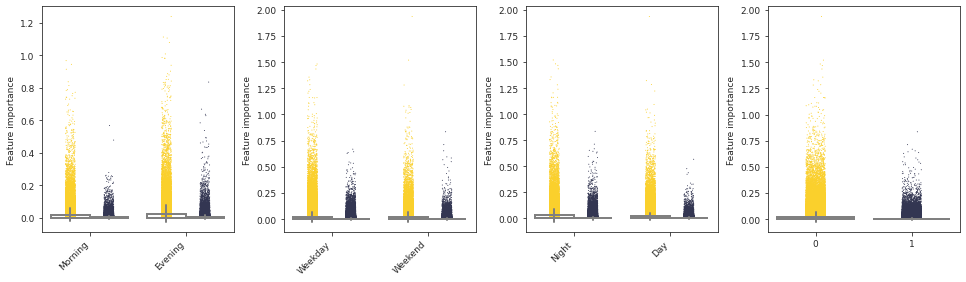

In [75]:
imp_panel(res_lt4wk, 'gt4wk')


### add corr vals to these?

In [625]:
import importlib
importlib.reload(weartabcorr)

<module 'wearables.scripts.correlate_tabular_data' from '/home/ngrav/project/wearables/scripts/correlate_tabular_data.py'>

In [636]:
paired_cmap = ['#007172', '#F29325']


In [536]:
# load old data
fname = 'featattr_res_220310.pkl'

with open(os.path.join(pfp, fname), 'rb') as f:
    results_all = pickle.load(f)
    f.close()
    
res = results_all['res_err_grps']

md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
res['abs_attr'] = res['attr'].abs()
dt = res.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [643]:
dt['morningVevening'].unique()

array(['Evening', 'Morning', 'NA'], dtype=object)

In [649]:
a = weartabcorr.elasticnet(dt.loc[dt['morningVevening']=='Evening', :], 'abs_attr', 'sleep')
b = weartabcorr.elasticnet(dt.loc[dt['morningVevening']=='Morning', :], 'abs_attr', 'sleep')

Text(0, 0.5, 'TPR')

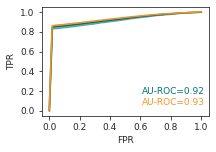

In [650]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
# case 1
ax.plot(a[0], np.mean(a[1], 0), color=paired_cmap[0])
ax.fill_between(a[0], np.mean(a[1], 0) - np.std(a[1], 0), np.mean(a[1], 0) + np.std(a[1], 0), color=paired_cmap[0], alpha=0.5)
ax.text(0.6, 0.2, f'AU-ROC={np.mean(a[2]):.2f}', transform=ax.transAxes, color=paired_cmap[0]) #  ({np.std(mve[2]):.1f})
# case 2
ax.plot(b[0], np.mean(b[1], 0), color=paired_cmap[1])
ax.fill_between(b[0], np.mean(b[1], 0) - np.std(b[1], 0), np.mean(b[1], 0) + np.std(b[1], 0), color=paired_cmap[1], alpha=0.5)
ax.text(0.6, 0.1, f'AU-ROC={np.mean(b[2]):.2f}', transform=ax.transAxes, color=paired_cmap[1]) #  ({np.std(mve[2]):.1f})

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

### show prop zero instead 

In [651]:
dt.head()

,index,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr,...,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,PQSI,KPAS,EpworthSS,Edinburgh,GA,yhat,error
0,4279,0.000000,1359_8,1,2018-03-03 23:19:00,Evening,Weekend,Night,lt10wks,0.000000,...,2.839998,3.986419,1.603738,7.0,12.580303,4.0,0.0,8.0,12.707663,4.707663
1,5038,0.006992,2339_35,0,2019-01-28 11:58:00,Morning,Weekday,Day,Lower-than-actual,0.006992,...,2.009012,3.048842,0.629052,15.0,7.638745,10.0,17.0,35.0,22.707096,-12.292904
2,7062,-0.007316,1405_36,1,2018-08-07 21:42:00,Evening,Weekday,Night,Lower-than-actual,0.007316,...,2.328660,2.620087,1.968015,4.0,4.571429,0.0,0.0,36.0,20.415503,-15.584497
3,1678,0.000000,2570_11,1,2019-05-11 03:58:00,NA,Weekend,Night,lt10wks,0.000000,...,2.296961,2.555295,0.726078,11.0,10.864646,11.0,2.0,11.0,15.323212,4.323212
4,6670,-0.023203,2622_32,0,2020-02-05 15:10:00,NA,Weekday,Day,Lower-than-actual,0.023203,...,2.737235,4.111298,1.105710,8.0,9.082468,2.0,0.0,32.0,18.454264,-13.545736


In [657]:
grp = []
for i in specs['morningVevening']:
    grp.append(i + ' sleep')
    grp.append(i + ' wake')
    

In [665]:
slp_cmap = {'Wake':'#FAD02C', 'Sleep':'#333652'}

In [667]:
dtt = dt.loc[(dt[k]==v[0]) & (dt['sleep']==1), 'abs_attr']

In [673]:
(dtt < 1e-8).sum() / dtt.shape

array([0.87318824])

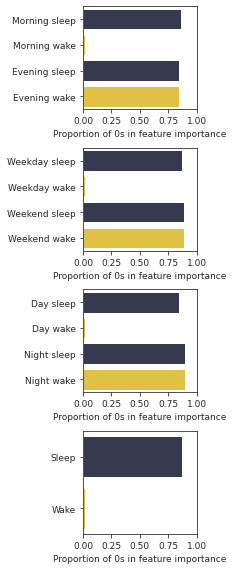

In [680]:
tol = 1e-8
specs = {'morningVevening': ['Morning', 'Evening'],
         'weekdayVweekend': ['Weekday', 'Weekend'],
         'dayVnight': ['Day', 'Night'],
         'sleep': [1, 0],}
fig = plt.figure(figsize=(3, 8))
for i, (k, v) in enumerate(specs.items()):
    ax = fig.add_subplot(4, 1, i+1)
    if k!='sleep':
        p_a1 = (dt.loc[(dt[k]==v[0]) & (dt['sleep']==1), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[0]) & (dt['sleep']==1), 'abs_attr'].shape[0]
        p_a0 = (dt.loc[(dt[k]==v[0]) & (dt['sleep']==0), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[0]) & (dt['sleep']==0), 'abs_attr'].shape[0]
        p_b1 = (dt.loc[(dt[k]==v[1]) & (dt['sleep']==1), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[1]) & (dt['sleep']==1), 'abs_attr'].shape[0]
        p_b0 = (dt.loc[(dt[k]==v[1]) & (dt['sleep']==0), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[1]) & (dt['sleep']==0), 'abs_attr'].shape[0]
        grp = []
        for i in specs[k]:
            grp.append(i + ' sleep')
            grp.append(i + ' wake')
        dtt = pd.DataFrame({'Proportion of 0s': [p_a1, p_a0, p_b1, p_b1], 'Group': grp,
                            'slp': ['Sleep', 'Wake']*2})
    else:
        p_a = (dt.loc[(dt[k]==v[0]), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[0]), 'abs_attr'].shape[0]
        p_b = (dt.loc[(dt[k]==v[1]), 'abs_attr'] <= tol).sum() / dt.loc[(dt[k]==v[1]), 'abs_attr'].shape[0]
        dtt = pd.DataFrame({'Proportion of 0s': [p_a, p_b], 'Group': ['Sleep', 'Wake'],
                            'slp': ['Sleep', 'Wake']})
    sns.barplot(x='Proportion of 0s', y='Group', data=dtt, hue='slp', 
                dodge=False, palette=slp_cmap)#palette={kk: paired_cmap[i] for i, kk in enumerate(specs[k])})
    ax.set_ylabel('')
    ax.set_xlim([0, 1])
    ax.legend().set_visible(False)
    ax.set_xlabel('Proportion of 0s in feature importance')
    
fig.tight_layout()

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_todgrpVp0.pdf'), bbox_inches='tight')
    

## feat attr V. clinical var

NOTE: for doubling the length of sample, it is roughly doubling the computation time... thus... the algorithm is linear. 

In [398]:
# exclude_md_vars = ['record_id', 'split', 'y'] + [i for i in res.columns if i in md.columns]
# coi = [i for i in md.columns if i not in exclude_md_vars]

In [399]:
from wearables.scripts.md_specification import mdpred_voi_v2
from wearables.scripts import correlate_tabular_data as weartabcorr

In [419]:
# load old data
fname = 'featattr_res_220310.pkl'

with open(os.path.join(pfp, fname), 'rb') as f:
    results_all = pickle.load(f)
    f.close()
    
res = results_all['res_err_grps']

In [436]:
res.head()

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr
0,0.0,2283_23,1,2018-08-21 00:00:00,NA,Weekday,Night,lt10wks,0.0
1,0.0,2283_23,1,2018-08-21 00:01:00,NA,Weekday,Night,lt10wks,0.0
2,0.0,2283_23,1,2018-08-21 00:02:00,NA,Weekday,Night,lt10wks,0.0
3,0.0,2283_23,1,2018-08-21 00:03:00,NA,Weekday,Night,lt10wks,0.0
4,0.0,2283_23,1,2018-08-21 00:04:00,NA,Weekday,Night,lt10wks,0.0


In [420]:
md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
res['abs_attr'] = res['attr'].abs()
dt = res.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [421]:
dt.head()

,index,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr,...,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,PQSI,KPAS,EpworthSS,Edinburgh,GA,yhat,error
0,10059,0.0,1022_36,1,2017-10-16 23:39:00,Evening,Weekday,Night,Lower-than-actual,0.0,...,0.595655,0.587422,0.268643,11.0,8.953247,6.0,1.0,36.0,17.972786,-18.027214
1,8765,0.0,1220_8,1,2017-10-27 02:05:00,NA,Weekday,Night,Higher-than-actual,0.0,...,3.253652,3.513088,2.614156,8.0,10.578139,6.0,0.0,8.0,18.802256,10.802256
2,5929,0.0,2343_35,1,2018-12-18 02:49:00,NA,Weekday,Night,Lower-than-actual,0.0,...,3.500232,5.250998,1.704789,4.0,4.571429,0.0,0.0,35.0,24.866127,-10.133873
3,7963,0.0,1511_24,1,2018-11-07 12:43:00,NA,Weekday,Day,lt10wks,0.0,...,0.286501,0.245521,0.224331,10.0,8.764286,15.0,0.0,24.0,23.347395,-0.652605
4,7434,0.0,1062_13,1,2017-06-26 03:54:00,NA,Weekday,Night,Higher-than-actual,0.0,...,3.144995,4.226732,1.163481,9.0,9.286147,5.0,1.0,13.0,24.246517,11.246517


In [423]:
# the all grouping will be redundant but OH WELL
for g in ['morningVevening', 'weekdayVweekend', 'dayVnight', 'sleep', 'group']:
    results_all['impcorr_{}'.format(g)] = weartabcorr.colVall_corr(dt, 'abs_attr', mdpred_voi_v2, groupby=g)

Starting grp: all
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 293-s
  through 101 of 129 vars in 1312-s

  ... through grp all in 24.8-min
Starting grp: Evening
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 39-s
  through 101 of 129 vars in 163-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

only one val for dayVnight
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp Evening in 3.0-min
Starting grp: NA
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 108-s
  through 101 of 129 vars in 482-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp NA in 8.9-min
Starting grp: Morning
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 39-s
  through 101 of 129 vars in 163-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. S

In [424]:
errcor_vois = {}
for i in mdpred_voi_v2.keys():
    if i in md.columns:
        errcor_vois[i] = mdpred_voi_v2[i]


In [425]:
# add md corr as well but for the error 
errgrpcorr = weartabcorr.colVall_corr(md, 'error', errcor_vois, groupby='Error group')
results_all['errcorr'] = errgrpcorr

Starting grp: all
  through 1 of 124 vars in 0-s
  through 51 of 124 vars in 2-s
  through 101 of 124 vars in 7-s

edinb10_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb10_1trim class frequencies:
j: 0	0: 2445	1: 18
j: 1	0: 85	1: 2378
j: 2	0: 2418	1: 45
j: 3	0: 2443	1: 20
j: 4	0: 2461	1: 2

  ... through grp all in 0.1-min
Starting grp: lt10wks
  through 1 of 124 vars in 0-s
  through 51 of 124 vars in 2-s
  through 101 of 124 vars in 7-s

edinb10_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb10_1trim class frequencies:
j: 0	0: 1803	1: 15
j: 1	0: 65	1: 1753
j: 2	0: 1786	1: 32
j: 3	0: 1802	1: 16
j: 4	0: 1816	1: 2

  ... through grp lt10wks in 0.1-min
Starting grp: Higher-than-actual
  through 1 of 124 vars in 0-s

gestage_by's 4-th class cannot be computed. Too few n_samples. Skipping
gestage_by class frequencies:
j: 0	0: 238	1: 11
j: 1	0: 149	1: 100
j: 2	0: 160	1: 89
j: 3	0: 201	1: 48
j: 4	0: 248	1: 1

insur's 0-th class cannot be com

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


abuse's 0-th class cannot be computed. Too few n_samples. Skipping
abuse class frequencies:
j: 0	0: 246	1: 3

error:abuse association cannot be computed: no model completed

anes_type's 4-th class cannot be computed. Too few n_samples. Skipping
anes_type class frequencies:
j: 0	0: 187	1: 62
j: 1	0: 125	1: 124
j: 2	0: 225	1: 24
j: 3	0: 215	1: 34
j: 4	0: 246	1: 3
j: 5	0: 247	1: 2

anes_type's 5-th class cannot be computed. Too few n_samples. Skipping
anes_type class frequencies:
j: 0	0: 187	1: 62
j: 1	0: 125	1: 124
j: 2	0: 225	1: 24
j: 3	0: 215	1: 34
j: 4	0: 246	1: 3
j: 5	0: 247	1: 2
  through 51 of 124 vars in 1-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


inactive1's 5-th class cannot be computed. Too few n_samples. Skipping
inactive1 class frequencies:
j: 0	0: 216	1: 33
j: 1	0: 122	1: 127
j: 2	0: 207	1: 42
j: 3	0: 219	1: 30
j: 4	0: 235	1: 14
j: 5	0: 246	1: 3


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


talking1's 4-th class cannot be computed. Too few n_samples. Skipping
talking1 class frequencies:
j: 0	0: 216	1: 33
j: 1	0: 62	1: 187
j: 2	0: 232	1: 17
j: 3	0: 240	1: 9
j: 4	0: 247	1: 2
j: 5	0: 248	1: 1

talking1's 5-th class cannot be computed. Too few n_samples. Skipping
talking1 class frequencies:
j: 0	0: 216	1: 33
j: 1	0: 62	1: 187
j: 2	0: 232	1: 17
j: 3	0: 240	1: 9
j: 4	0: 247	1: 2
j: 5	0: 248	1: 1


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


edinb1_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb1_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 34	1: 215
j: 2	0: 222	1: 27
j: 3	0: 244	1: 5
j: 4	0: 248	1: 1

edinb1_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb1_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 34	1: 215
j: 2	0: 222	1: 27
j: 3	0: 244	1: 5
j: 4	0: 248	1: 1

edinb2_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb2_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 48	1: 201
j: 2	0: 211	1: 38
j: 3	0: 241	1: 8
j: 4	0: 248	1: 1

edinb2_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb2_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 48	1: 201
j: 2	0: 211	1: 38
j: 3	0: 241	1: 8
j: 4	0: 248	1: 1

edinb3_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb3_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 132	1: 117
j: 2	0: 171	1: 78
j: 3	0: 201	1: 48
j: 4	0: 244	1: 5

edinb4_1trim's 0-th class c

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


edinb5_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb5_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 87	1: 162
j: 2	0: 194	1: 55
j: 3	0: 219	1: 30
j: 4	0: 248	1: 1

edinb5_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb5_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 87	1: 162
j: 2	0: 194	1: 55
j: 3	0: 219	1: 30
j: 4	0: 248	1: 1
  through 101 of 124 vars in 5-s

edinb6_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb6_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 117	1: 132
j: 2	0: 176	1: 73
j: 3	0: 210	1: 39
j: 4	0: 245	1: 4

edinb7_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb7_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 58	1: 191
j: 2	0: 217	1: 32
j: 3	0: 229	1: 20
j: 4	0: 244	1: 5


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


edinb8_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb8_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 92	1: 157
j: 2	0: 177	1: 72
j: 3	0: 232	1: 17
j: 4	0: 247	1: 2

edinb8_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb8_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 92	1: 157
j: 2	0: 177	1: 72
j: 3	0: 232	1: 17
j: 4	0: 247	1: 2

edinb9_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb9_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 90	1: 159
j: 2	0: 178	1: 71
j: 3	0: 233	1: 16
j: 4	0: 247	1: 2

edinb9_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb9_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 90	1: 159
j: 2	0: 178	1: 71
j: 3	0: 233	1: 16
j: 4	0: 247	1: 2

edinb10_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb10_1trim class frequencies:
j: 0	0: 248	1: 1
j: 1	0: 8	1: 241
j: 2	0: 243	1: 6
j: 3	0: 248	1: 1

edinb10_1trim's 3-th class cannot be compu

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


smoke's 2-th class cannot be computed. Too few n_samples. Skipping
smoke class frequencies:
j: 0	0: 45	1: 351
j: 1	0: 352	1: 44
j: 2	0: 395	1: 1

hypertension's 2-th class cannot be computed. Too few n_samples. Skipping
hypertension class frequencies:
j: 0	0: 33	1: 363
j: 1	0: 364	1: 32
j: 2	0: 395	1: 1

pregestational_diabetes's 2-th class cannot be computed. Too few n_samples. Skipping
pregestational_diabetes class frequencies:
j: 0	0: 9	1: 387


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

j: 1	0: 389	1: 7
j: 2	0: 394	1: 2


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


other_disease's 2-th class cannot be computed. Too few n_samples. Skipping
other_disease class frequencies:
j: 0	0: 95	1: 301
j: 1	0: 302	1: 94
j: 2	0: 395	1: 1

abuse's 0-th class cannot be computed. Too few n_samples. Skipping
abuse class frequencies:
j: 0	0: 393	1: 3

error:abuse association cannot be computed: no model completed


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


anes_type's 4-th class cannot be computed. Too few n_samples. Skipping
anes_type class frequencies:
j: 0	0: 362	1: 34
j: 1	0: 128	1: 268
j: 2	0: 353	1: 43
j: 3	0: 349	1: 47
j: 4	0: 394	1: 2
j: 5	0: 395	1: 1
j: 6	0: 395	1: 1

anes_type's 5-th class cannot be computed. Too few n_samples. Skipping
anes_type class frequencies:
j: 0	0: 362	1: 34
j: 1	0: 128	1: 268
j: 2	0: 353	1: 43
j: 3	0: 349	1: 47
j: 4	0: 394	1: 2
j: 5	0: 395	1: 1
j: 6	0: 395	1: 1

anes_type's 6-th class cannot be computed. Too few n_samples. Skipping
anes_type class frequencies:
j: 0	0: 362	1: 34
j: 1	0: 128	1: 268
j: 2	0: 353	1: 43
j: 3	0: 349	1: 47
j: 4	0: 394	1: 2
j: 5	0: 395	1: 1
j: 6	0: 395	1: 1
  through 51 of 124 vars in 1-s

deliv_mode's 3-th class cannot be computed. Too few n_samples. Skipping
deliv_mode class frequencies:
j: 0	0: 135	1: 261
j: 1	0: 378	1: 18
j: 2	0: 280	1: 116
j: 3	0: 395	1: 1

death_baby's 0-th class cannot be computed. Too few n_samples. Skipping
death_baby class frequencies:
j: 0	0: 393	1:

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


cartraffic1's 4-th class cannot be computed. Too few n_samples. Skipping
cartraffic1 class frequencies:
j: 0	0: 385	1: 11
j: 1	0: 79	1: 317
j: 2	0: 357	1: 39
j: 3	0: 381	1: 15
j: 4	0: 394	1: 2
j: 5	0: 384	1: 12

edinb1_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb1_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 57	1: 339
j: 2	0: 350	1: 46
j: 3	0: 392	1: 4
j: 4	0: 391	1: 5

edinb2_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb2_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 101	1: 295
j: 2	0: 317	1: 79
j: 3	0: 381	1: 15
j: 4	0: 391	1: 5


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


edinb3_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb3_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 213	1: 183
j: 2	0: 261	1: 135
j: 3	0: 326	1: 70
j: 4	0: 390	1: 6

edinb4_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb4_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 224	1: 172
j: 2	0: 306	1: 90
j: 3	0: 273	1: 123
j: 4	0: 387	1: 9

edinb5_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb5_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 136	1: 260
j: 2	0: 324	1: 72
j: 3	0: 338	1: 58
j: 4	0: 392	1: 4


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

  through 101 of 124 vars in 6-s

edinb6_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb6_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 200	1: 196
j: 2	0: 264	1: 132
j: 3	0: 331	1: 65
j: 4	0: 395	1: 1

edinb6_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb6_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 200	1: 196
j: 2	0: 264	1: 132
j: 3	0: 331	1: 65
j: 4	0: 395	1: 1

edinb7_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb7_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 114	1: 282
j: 2	0: 336	1: 60
j: 3	0: 349	1: 47
j: 4	0: 391	1: 5

edinb8_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb8_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 131	1: 265
j: 2	0: 293	1: 103
j: 3	0: 372	1: 24
j: 4	0: 394	1: 2


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


edinb8_1trim's 4-th class cannot be computed. Too few n_samples. Skipping
edinb8_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 131	1: 265
j: 2	0: 293	1: 103
j: 3	0: 372	1: 24
j: 4	0: 394	1: 2

edinb9_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb9_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 143	1: 253
j: 2	0: 283	1: 113
j: 3	0: 372	1: 24
j: 4	0: 392	1: 4

edinb10_1trim's 0-th class cannot be computed. Too few n_samples. Skipping
edinb10_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 12	1: 384
j: 2	0: 389	1: 7
j: 3	0: 393	1: 3

edinb10_1trim's 3-th class cannot be computed. Too few n_samples. Skipping
edinb10_1trim class frequencies:
j: 0	0: 394	1: 2
j: 1	0: 12	1: 384
j: 2	0: 389	1: 7
j: 3	0: 393	1: 3

  ... through grp Lower-than-actual in 0.1-min


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

In [426]:
# interim save, due to time-consuming process
fname = 'featattr_res_220310.pkl'
with open(os.path.join(pfp, fname), 'wb') as f:
    pickle.dump(results_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [427]:
!mail -s "done with the corr of imp and err with md and other grps" ngravindra@gmail.com <<< "4theplots, you batch"

In [403]:
# now with err group
# the all grouping will be redundant but OH WELL
for g in ['morningVevening', 'weekdayVweekend', 'dayVnight', 'sleep', 'group']:
    results_all['errcorr_{}'.format(g)] = weartabcorr.colVall_corr(dt, 'error', mdpred_voi_v2, groupby=g)

Starting grp: all
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 134-s
  through 101 of 129 vars in 573-s

  ... through grp all in 10.6-min
Starting grp: NA
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 67-s
  through 101 of 129 vars in 282-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp NA in 5.2-min
Starting grp: Morning
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 34-s
  through 101 of 129 vars in 137-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

only one val for dayVnight
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp Morning in 2.5-min
Starting grp: Evening
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 33-s
  through 101 of 129 vars in 137-s

only one val for morningVevening
... cannot fit one class only. Reconsider its inclusion. Ski

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

  through 51 of 129 vars in 46-s
  through 101 of 129 vars in 183-s

only one val for sleep
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

  ... through grp 0 in 3.4-min
Starting grp: all
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 141-s
  through 101 of 129 vars in 601-s

  ... through grp all in 11.2-min
Starting grp: Higher-than-actual
  through 1 of 129 vars in 0-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


only one val for asthma_yes___5
... cannot fit one class only. Reconsider its inclusion. Skipping this var.

only one val for asthma_yes___10
... cannot fit one class only. Reconsider its inclusion. Skipping this var.


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


only one val for assist_repro
... cannot fit one class only. Reconsider its inclusion. Skipping this var.
  through 51 of 129 vars in 53-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

  through 101 of 129 vars in 196-s

  ... through grp Higher-than-actual in 3.5-min
Starting grp: lt10wks
  through 1 of 129 vars in 0-s
  through 51 of 129 vars in 48-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

  through 101 of 129 vars in 199-s

  ... through grp lt10wks in 3.7-min
Starting grp: Lower-than-actual
  through 1 of 129 vars in 0-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

  through 51 of 129 vars in 40-s
  through 101 of 129 vars in 165-s

  ... through grp Lower-than-actual in 3.0-min


In [404]:
# interim save, due to time-consuming process
fname = 'featattr_res_220310.pkl'
with open(os.path.join(pfp, fname), 'wb') as f:
    pickle.dump(results_all, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [405]:
!mail -s "done with the corr of err with other grps" ngravindra@gmail.com <<< "4theplots, you batch"

## association of (imp OR err) AND (md OR err grp)

### error correlations with (md_vars OR err_grp)

in main, show key ones. Bury others in supplement and show some specific distributions in main plot

In [412]:
from wearables.scripts.aesthetics import md_node_annotation, md_node_category_cmap
grp_cmap = {
    'all': '#F67280',
    'Higher-than-actual': '#C06C84',
    'Lower-than-actual': '#6C5B7B',
    'lt10wks': '#355C7D',
}

In [431]:
results_all.keys()

dict_keys(['res_4wk', 'res_err_grps', 'res_errgrp_ptb', 'imp_errgrp_mdvar_corrs', 'errcorr', 'errcorr_morningVevening', 'errcorr_weekdayVweekend', 'errcorr_dayVnight', 'errcorr_sleep', 'errcorr_group', 'impcorr_morningVevening', 'impcorr_weekdayVweekend', 'impcorr_dayVnight', 'impcorr_sleep', 'impcorr_group'])

In [393]:
# g = sns.FacetGrid(data=dt.loc[dt['variable']!='all'], row='variable', col='cat', hue='cat', palette=md_node_category_cmap)
# g = sns.FacetGrid(data=dt.loc[dt['variable']=='diff_slpVwake'], row='variable', col='cat', hue='cat', palette=md_node_category_cmap)
# g.map(sns.barplot, 'index', 'value', dodge=True)
# for axes in g.axes.flat:
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#     axes.set_xlabel('')
    

In [413]:
savefigs = True

In [415]:
diff_specs = {'errcorr_morningVevening': ['Morning', 'Evening'], 
              'errcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'errcorr_dayVnight': ['Day', 'Night'],
              'errcorr_sleep': [1, 0],
              'errcorr_group': []}

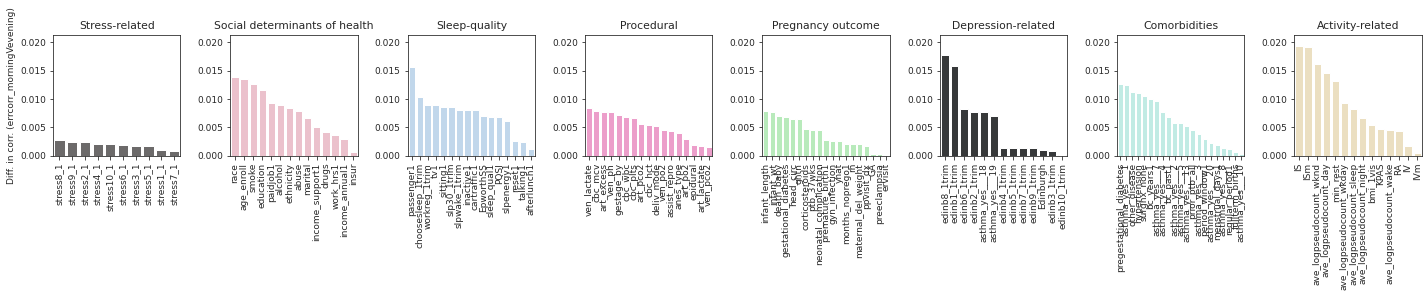

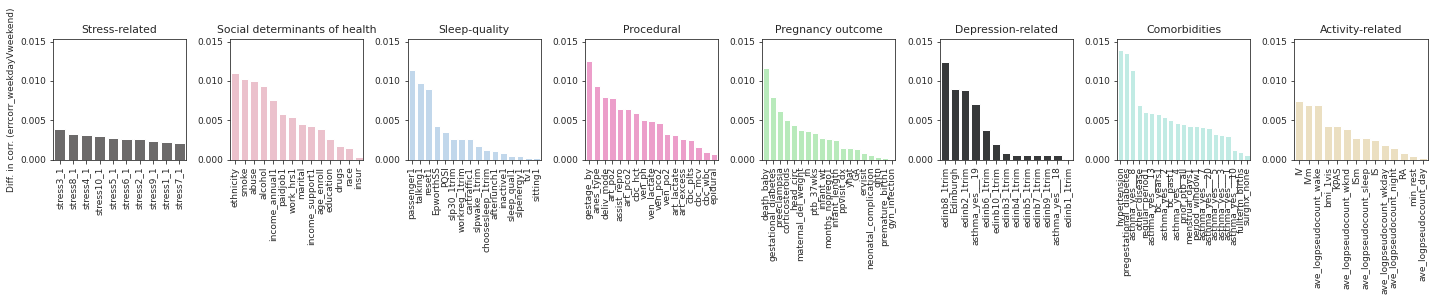

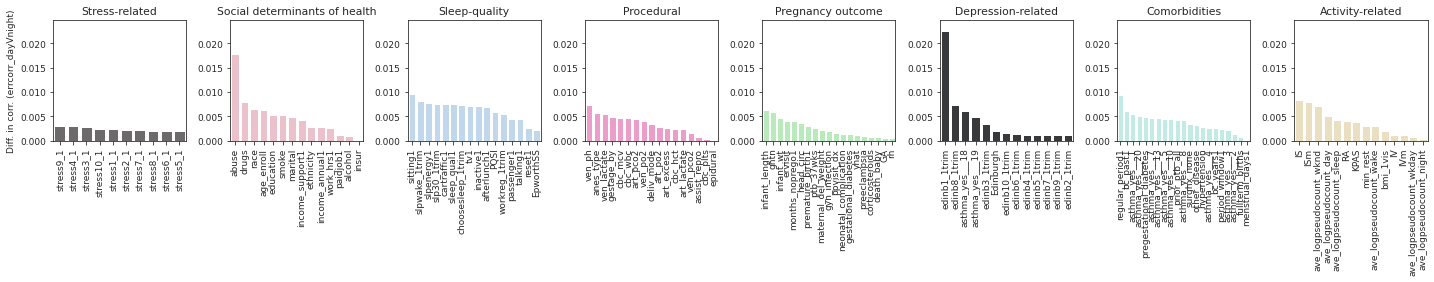

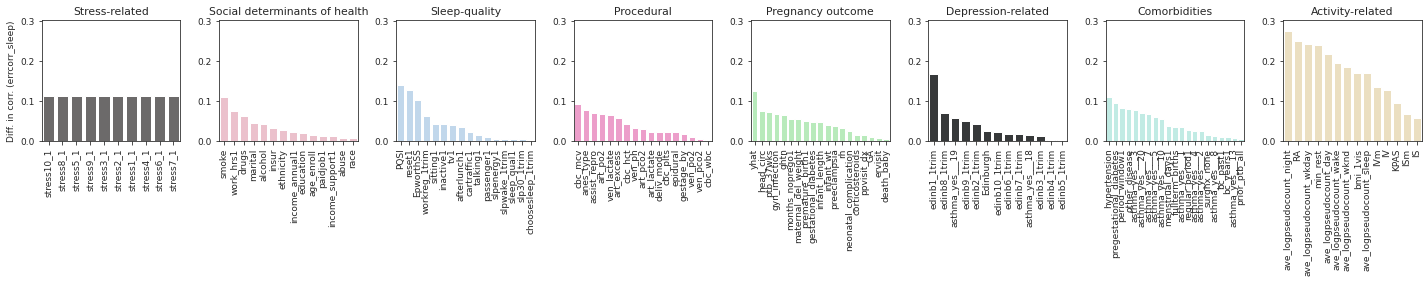

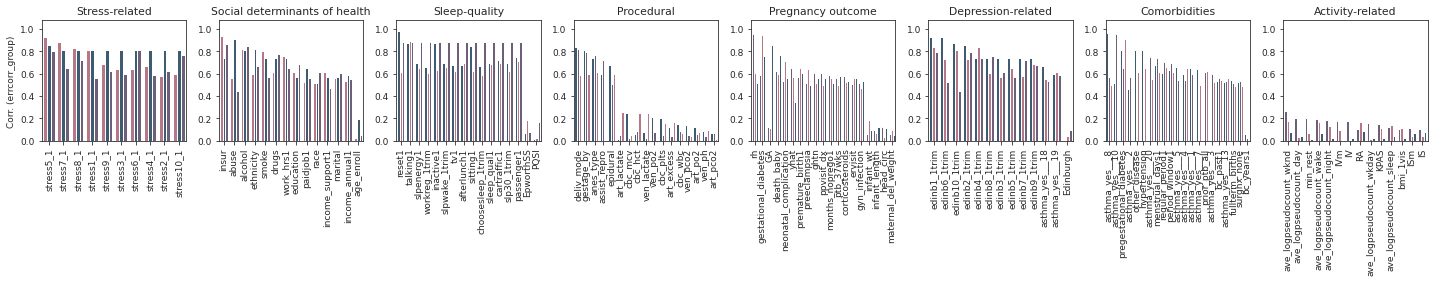

In [416]:
# wrangle df
for k_a, v in diff_specs.items():
    dt = results_all[k_a]
    if len(v) > 0:
        dt['diff'] = dt[v[0]] - dt[v[1]]
    dt['cat'] = dt.index.map(md_node_annotation)
    dt = dt.loc[~dt['cat'].isna()]
    dt = dt.reset_index().melt(id_vars=['cat', 'index'])
    dt['value'] = dt['value'].abs()
    dt = dt.sort_values(by=['cat', 'value'], ascending=False)

    # plot
    if len(v) > 0:
        dtt = dt.loc[(dt['variable']=='diff')]
    else:
        dtt = dt.loc[dt['variable']!='all']

    fig = plt.figure(figsize=(20, 4))
    for i, cat in enumerate(dt['cat'].unique()):
        ax = fig.add_subplot(1, 8, i+1)
        if len(v) > 0:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='cat', palette=md_node_category_cmap, ax=ax)
        else:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if len(v) > 0:
                ax.set_ylabel(f'Diff. in corr. ({k_a})')
            else:
                ax.set_ylabel(f'Corr. ({k_a})')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)
        ax.set_title(cat)
        ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
    fig.tight_layout()
    
    if savefigs:
        fig.savefig(os.path.join(pfp, 'barplot_{}.pdf'.format(k_a)), bbox_inches='tight', dpi=600)

## importance correlations

### impcorr with (md_vars OR err grp) 

In [429]:
diff_specs = {'impcorr_morningVevening': ['Morning', 'Evening'], 
              'impcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'impcorr_dayVnight': ['Day', 'Night'],
              'impcorr_sleep': [1, 0],
              'impcorr_group': []}

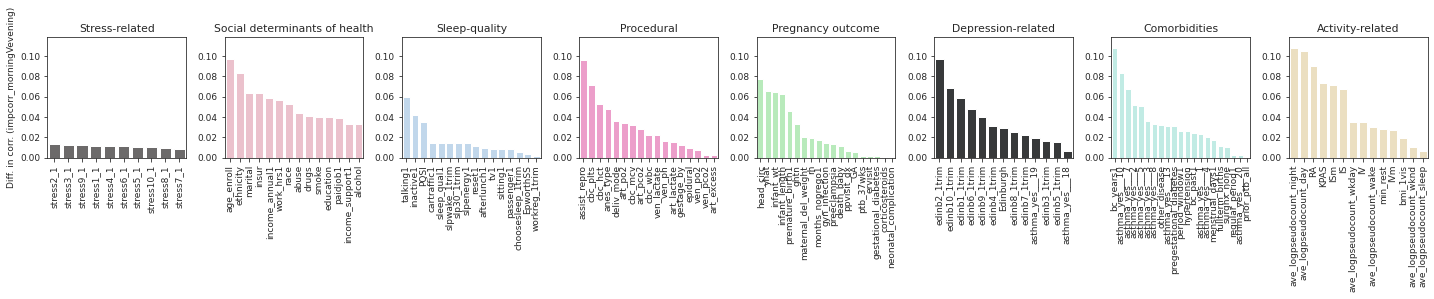

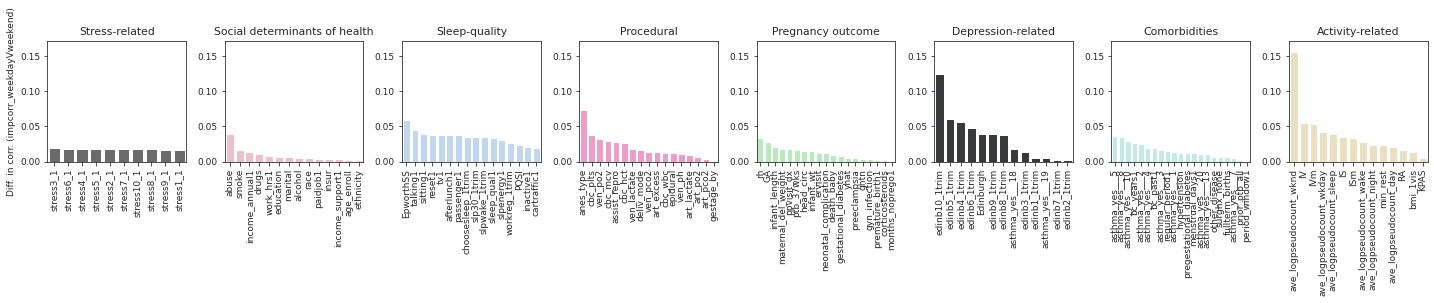

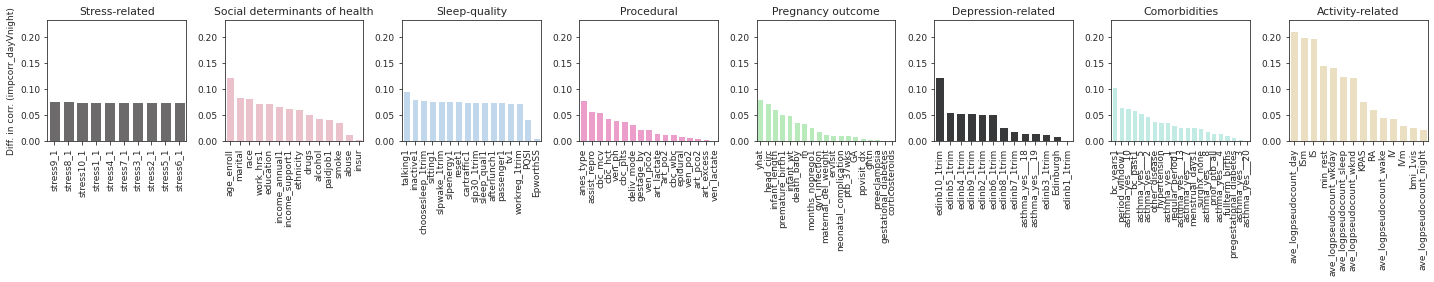

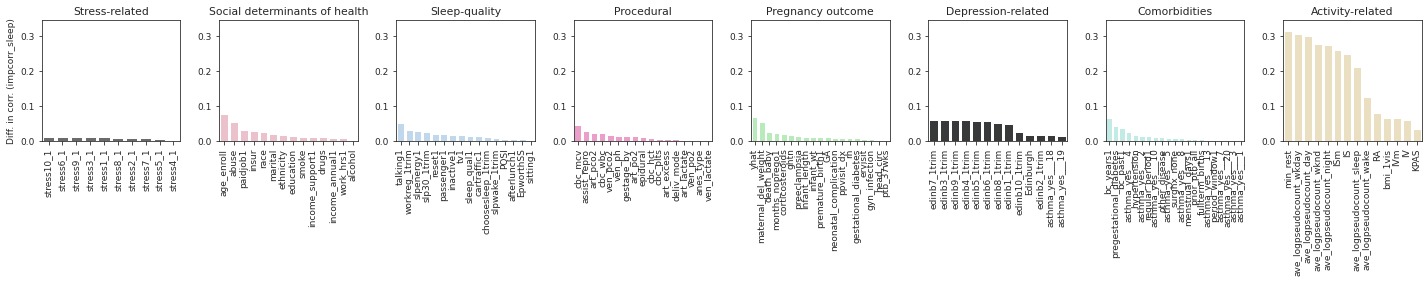

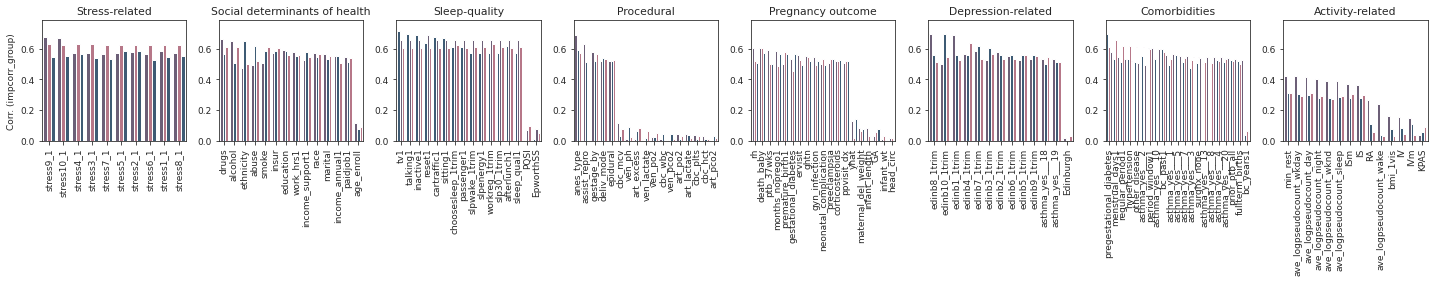

In [430]:
# wrangle df
for k_a, v in diff_specs.items():
    dt = results_all[k_a]
    if len(v) > 0:
        dt['diff'] = dt[v[0]] - dt[v[1]]
    dt['cat'] = dt.index.map(md_node_annotation)
    dt = dt.loc[~dt['cat'].isna()]
    dt = dt.reset_index().melt(id_vars=['cat', 'index'])
    dt['value'] = dt['value'].abs()
    dt = dt.sort_values(by=['cat', 'value'], ascending=False)

    # plot
    if len(v) > 0:
        dtt = dt.loc[(dt['variable']=='diff')]
    else:
        dtt = dt.loc[dt['variable']!='all']

    fig = plt.figure(figsize=(20, 4))
    for i, cat in enumerate(dt['cat'].unique()):
        ax = fig.add_subplot(1, 8, i+1)
        if len(v) > 0:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='cat', palette=md_node_category_cmap, ax=ax)
        else:
            sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            if len(v) > 0:
                ax.set_ylabel(f'Diff. in corr. ({k_a})')
            else:
                ax.set_ylabel(f'Corr. ({k_a})')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)
        ax.set_title(cat)
        ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
    fig.tight_layout()
    
    if savefigs:
        fig.savefig(os.path.join(pfp, 'barplot_{}.pdf'.format(k_a)), bbox_inches='tight', dpi=600)

## specifics of imp/err corr by errgrp

In [487]:
results_all.keys()

dict_keys(['res_4wk', 'res_err_grps', 'res_errgrp_ptb', 'imp_errgrp_mdvar_corrs', 'errcorr', 'errcorr_morningVevening', 'errcorr_weekdayVweekend', 'errcorr_dayVnight', 'errcorr_sleep', 'errcorr_group', 'impcorr_morningVevening', 'impcorr_weekdayVweekend', 'impcorr_dayVnight', 'impcorr_sleep', 'impcorr_group'])

In [491]:
diff_specs = {'errcorr_morningVevening': ['Morning', 'Evening'], 
              'errcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'errcorr_dayVnight': ['Day', 'Night'],
              'errcorr_sleep': [1, 0],
              'errcorr_group': ['lt10wks', 'Lower-than-actual', 'Higher-than-actual'],
             
              'impcorr_morningVevening': ['Morning', 'Evening'], 
              'impcorr_weekdayVweekend': ['Weekday', 'Weekend'],
              'impcorr_dayVnight': ['Day', 'Night'],
              'impcorr_sleep': [1, 0],
              'impcorr_group': ['lt10wks', 'Lower-than-actual', 'Higher-than-actual']}

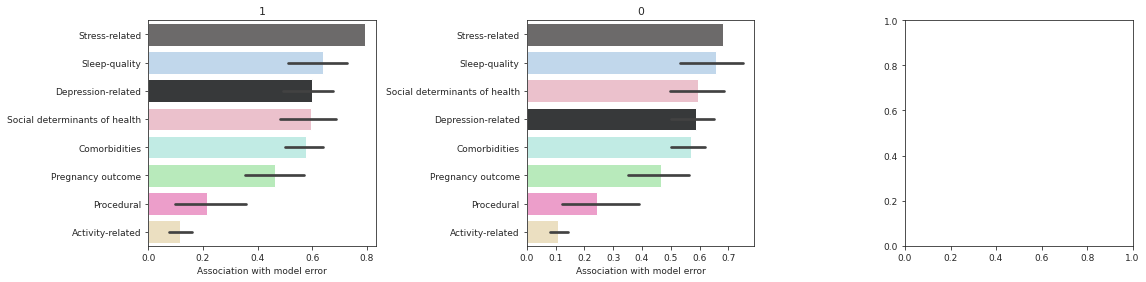

In [501]:
k_a = 'errcorr_sleep'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(diff_specs[k_a]):
    dtt = dt.loc[dt['variable']==v, :]
    # dtt['cat'] = pd.Categorical(dtt['cat'], 
    #            categories=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='cat', ascending=False)['cat'].to_list(),
    #            ordered=True)
    # dtt = dtt.groupby('cat')['value'].mean().reset_index()
    # dtt = dtt.sort_values(by='
    sns.barplot(y='cat', x='value',
                # estimator=np.max,
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with model error')
    # del dtt
fig.tight_layout()


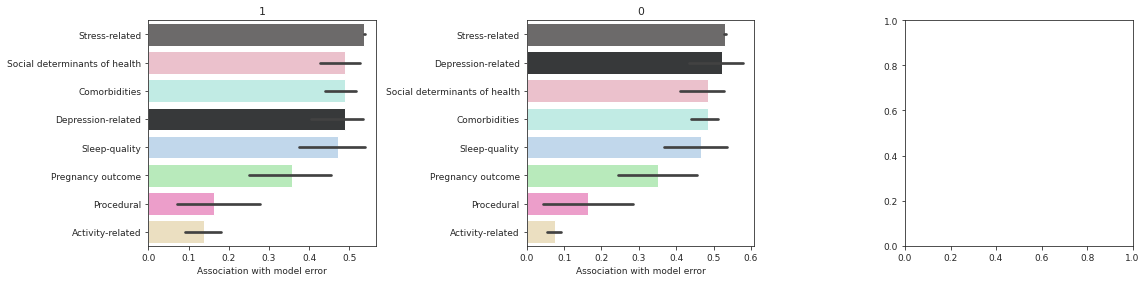

In [500]:
k_a = 'impcorr_sleep'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(diff_specs[k_a]):
    dtt = dt.loc[dt['variable']==v, :]
    sns.barplot(y='cat', x='value',
                # estimator=np.max,
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with model error')
    # del dtt
fig.tight_layout()


In [498]:
dtt.loc[dt['cat']=='Stress-related']

,cat,index,variable,value
320,Stress-related,stress1_1,0,0.682326
321,Stress-related,stress2_1,0,0.681701
322,Stress-related,stress3_1,0,0.68237
323,Stress-related,stress4_1,0,0.682519
324,Stress-related,stress5_1,0,0.682034
325,Stress-related,stress6_1,0,0.68233
326,Stress-related,stress7_1,0,0.682491
327,Stress-related,stress8_1,0,0.682176
328,Stress-related,stress9_1,0,0.682011
329,Stress-related,stress10_1,0,0.68169


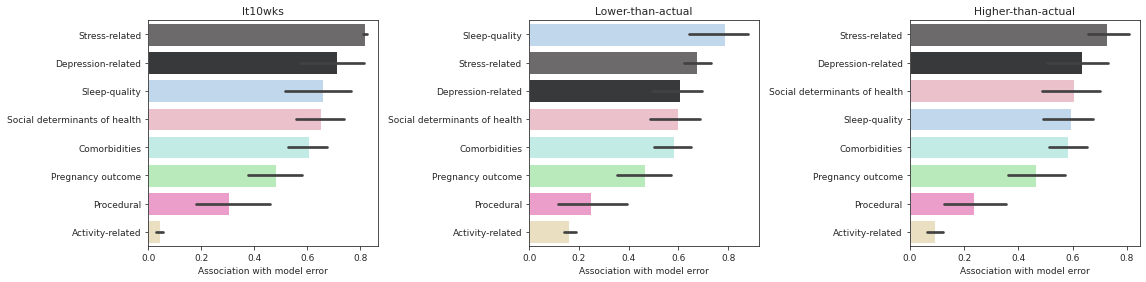

In [485]:
k_a = 'errcorr_group'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(['lt10wks', 'Lower-than-actual', 'Higher-than-actual']):
    dtt = dt.loc[dt['variable']==v, :]
    # dtt['cat'] = pd.Categorical(dtt['cat'], 
    #            categories=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='cat', ascending=False)['cat'].to_list(),
    #            ordered=True)
    # dtt = dtt.groupby('cat')['value'].mean().reset_index()
    # dtt = dtt.sort_values(by='
    sns.barplot(y='cat', x='value', 
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with model error')
    # del dtt
fig.tight_layout()

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_mdvarcatsVassoc_error.pdf'), bbox_inches='tight', dpi=600)

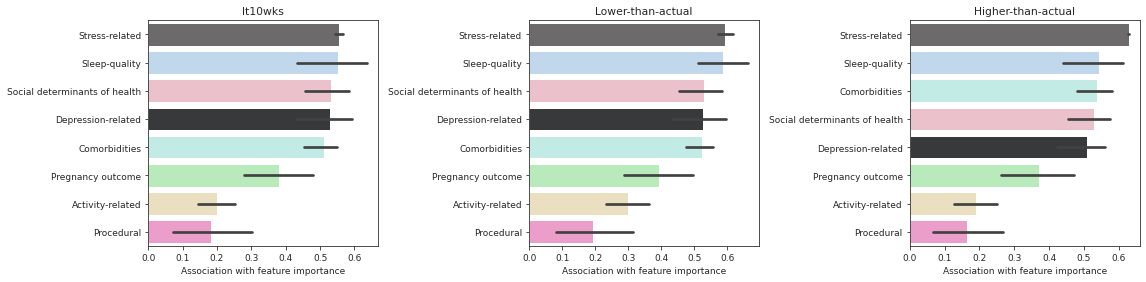

In [486]:
k_a = 'impcorr_group'
dt = results_all[k_a]
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt.head()

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i, v in enumerate(['lt10wks', 'Lower-than-actual', 'Higher-than-actual']):
    dtt = dt.loc[dt['variable']==v, :]
    # dtt['cat'] = pd.Categorical(dtt['cat'], 
    #            categories=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='cat', ascending=False)['cat'].to_list(),
    #            ordered=True)
    # dtt = dtt.groupby('cat')['value'].mean().reset_index()
    # dtt = dtt.sort_values(by='
    sns.barplot(y='cat', x='value', 
                data=dtt, 
                hue='cat', palette=md_node_category_cmap, 
                dodge=False, 
                ax=ax[i],
                order=dtt.groupby('cat')['value'].mean().reset_index().sort_values(by='value', ascending=False)['cat'].to_list())
    ax[i].legend().set_visible(False)
    ax[i].set_title(v)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Association with feature importance')
    # del dtt
fig.tight_layout()

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_mdvarcatsVassoc_importance.pdf'), bbox_inches='tight', dpi=600)

## specifics of imp/err corr by sleep

### ptb and IS

In [503]:
md_coi = [i for i in list(mdpred_voi_v2.keys()) if i in md.columns]
res['abs_attr'] = res['attr'].abs()
dt = res.merge(md.loc[:, md_coi], left_on='uid', right_index=True, how='left')

# sample? takes too long otherwise
if True:
    dt = dt.sample(200000).reset_index()

In [699]:
sleep_cmap = {0:'#FAD02C', 1:'#333652'}
ptb_cmap = {0: '#2F5061', 1: '#E57F84'}


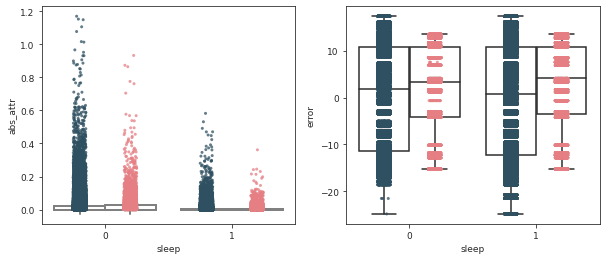

In [701]:
# select only 
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.stripplot(x='sleep', y='abs_attr', data=dt, rasterized=True, hue='ptb_37wks', 
              palette=ptb_cmap, dodge=True, ax=ax[0], s=3, alpha=0.75)
sns.barplot(x='sleep', y='abs_attr', 
                data=dt,
                facecolor='none', edgecolor='gray',
                errwidth=2,
                errcolor='gray',
                linewidth=2,
                hue='ptb_37wks',
                ci='sd',
                dodge=True,
                palette=ptb_cmap,
                zorder=1,
           ax=ax[0])
sns.stripplot(x='sleep', y='error', data=dt, rasterized=True, hue='ptb_37wks', 
              palette=ptb_cmap, dodge=True, ax=ax[1], s=3, alpha=0.75)
sns.boxplot(x='sleep', y='error', data=dt, hue='ptb_37wks', 
            palette=ptb_cmap,
            boxprops={'facecolor':'none'}, showfliers=False, ax=ax[1])
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
if savefigs:
    fig.savefig(os.path.join(pfp, 'stripplot_imp&errVsleep.pdf'), bbox_inches='tight', dpi=600, )

### AU-ROC and COEF from LR with SMOTE?

#### wrt to ptb

since just by tod doesn't look good

In [702]:
imp1 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==1, :], 'abs_attr', 'sleep')
imp0 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==0, :], 'abs_attr', 'sleep')
err1 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==1, :], 'error', 'sleep')
err0 = weartabcorr.elasticnet(dt.loc[dt['ptb_37wks']==0, :], 'error', 'sleep')


In [703]:
line_cmap = {
    'PTB+, Importance': '#533E85',
    'PTB-, Importance': '#488FB1',
    'PTB+, Error': '#4FD3C4',
    'PTB-, Error': '#C1F8CF',
}

In [709]:
def plot_auroc_out(a, ax, label, line_cmap):
    ax.plot(a[0], np.mean(a[1], 0), color=line_cmap[label], label=label)
    ax.fill_between(a[0], np.mean(a[1], 0) - np.std(a[1], 0), np.mean(a[1], 0) + np.std(a[1], 0), 
                    color=line_cmap[label], alpha=0.5)
    ax.text(0.6, 0.2, f'AU-ROC={np.mean(a[2]):.2f}', transform=ax.transAxes, color=paired_cmap[0]) #  ({np.std(mve[2]):.1f})
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()
    return ax

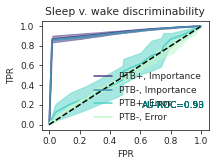

In [712]:

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
plot_auroc_out(imp1, ax, 'PTB+, Importance', line_cmap)
plot_auroc_out(imp0, ax, 'PTB-, Importance', line_cmap)
plot_auroc_out(err1, ax, 'PTB+, Error', line_cmap)
plot_auroc_out(err0, ax, 'PTB-, Error', line_cmap)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('Sleep v. wake discriminability')
if savefigs:
    fig.savefig(os.path.join(pfp, 'lineplot_tprVfpr_sleeppred_fromimperr_byptbgrp.pdf'), bbox_inches='tight')

# pval table with all these comparisons

heatmap plot of nlog10 pval between comparisons too

### corr plot with RA/IS and imp/err?

In [523]:
sleep_cmap = {0:'#FAD02C', 1:'#333652'}


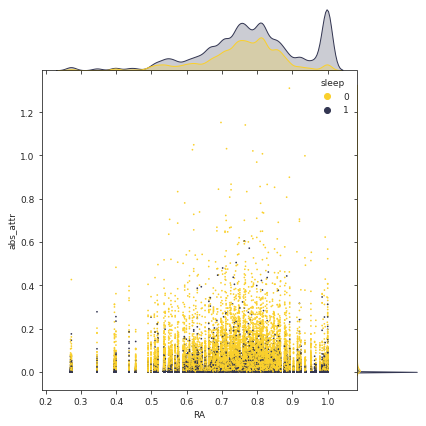

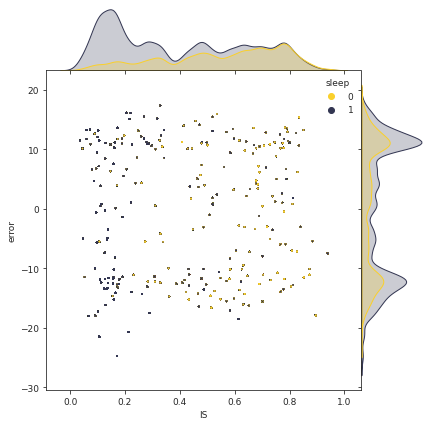

In [531]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
p1 = sns.jointplot(x='RA', y='abs_attr', data=dt, rasterized=True, hue='sleep', palette=sleep_cmap, linewidth=0, s=3, space=0)
# ax[0].set_yscale('log')
if savefigs:
    p1.savefig(os.path.join(pfp, 'joinplot_impVRA_byslp.pdf'), bbox_inches='tight', dpi=600)

p2 = sns.jointplot(x='IS', y='error', data=dt, hue='sleep', rasterized=True, ax=ax[1], linewidth=0, palette=sleep_cmap, s=3, space=0)
# ax[1].set_yscale('log')
if savefigs:
    p2.savefig(os.path.join(pfp, 'joinplot_errorVRA_byslp.pdf'), bbox_inches='tight', dpi=600)

### from md_vars/(err grp V t.o.d. grp)

## specifics of imp corr

### ptb and RA


In [512]:
sns.scatterplot(

,index,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr,...,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,PQSI,KPAS,EpworthSS,Edinburgh,GA,yhat,error
0,6166,0.000000,1373_6,1,2018-03-13 06:46:00,Morning,Weekday,Day,Higher-than-actual,0.000000,...,0.081658,0.041681,0.078801,7.0,8.638095,0.0,1.0,6.0,19.098871,13.098871
1,9354,-0.001650,2364_10,0,2018-09-06 11:54:00,Morning,Weekday,Day,lt10wks,0.001650,...,1.719062,1.835103,0.620700,10.0,9.752381,10.0,5.0,10.0,13.926222,3.926222
2,9935,-0.037208,2155_34,1,2018-05-07 21:35:00,Evening,Weekday,Night,lt10wks,0.037208,...,2.303561,3.374425,1.615426,10.0,9.545108,2.0,4.0,34.0,24.473131,-9.526869
3,6956,0.000000,1363_18,1,2018-05-16 19:56:00,Evening,Weekday,Night,lt10wks,0.000000,...,0.006253,0.008899,0.118510,9.0,7.160823,10.0,12.0,18.0,12.990560,-5.009440
4,7152,0.000000,2272_23,1,2018-06-24 23:12:00,Evening,Weekend,Night,lt10wks,0.000000,...,3.034900,3.451176,2.132498,8.0,9.217821,22.0,12.0,23.0,24.802345,1.802345


### from md_vars/(err grp V t.o.d. grp)

# dev

#### imp corrs for time-of-day

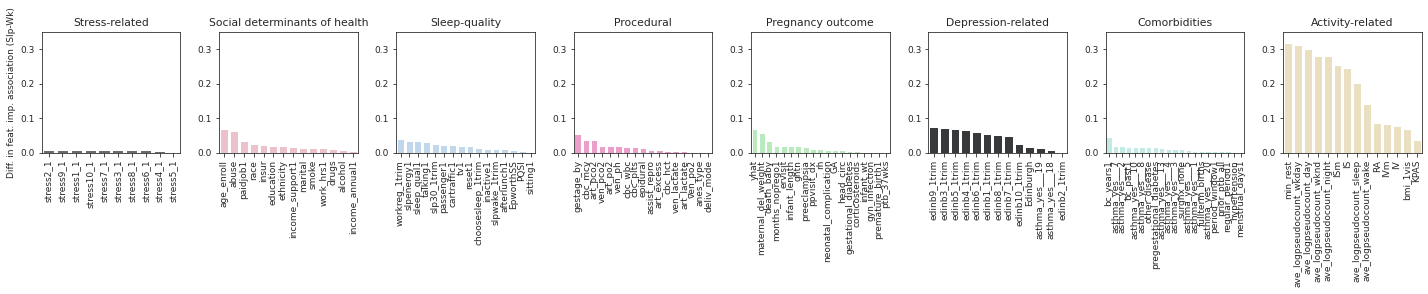

In [383]:
# wrangle df
for k_a in ['impcorr_sleep']:
    dt = results_all[k_a]
    if 'sleep' in k_a:
        dt['diff_slpVwake'] = dt[1] - dt[0]
    dt['cat'] = dt.index.map(md_node_annotation)
    dt = dt.loc[~dt['cat'].isna()]
    dt = dt.reset_index().melt(id_vars=['cat', 'index'])
    dt['value'] = dt['value'].abs()
    dt = dt.sort_values(by=['cat', 'value'], ascending=False)

    # plot
    if 'sleep' in k_a:
        dtt = dt.loc[(dt['variable']=='diff_slpVwake')]
    else:
        dtt = dt.loc[dt['variable']!='all']

    fig = plt.figure(figsize=(20, 4))
    for i, cat in enumerate(dt['cat'].unique()):
        ax = fig.add_subplot(1, 8, i+1)
        sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='cat', palette=md_node_category_cmap, ax=ax)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        if i==0:
            ax.set_ylabel(f'Diff. in feat. imp. association ({k_a})')
        else:
            ax.set_ylabel('')
        ax.legend().set_visible(False)
        ax.set_title(cat)
        ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
    fig.tight_layout()

### error groups

In [392]:
results_all['impcorr_group'].head()

,all,Higher-than-actual,lt10wks,Lower-than-actual,cat
age_enroll,0.100003,0.099261,0.070075,0.115917,Social determinants of health
marital,0.552686,0.553985,0.533627,0.56866,Social determinants of health
gestage_by,0.543018,0.583868,0.59413,0.579986,Procedural
insur,0.603481,0.600565,0.594954,0.572109,Social determinants of health
ethnicity,0.526058,0.499763,0.639179,0.489515,Social determinants of health


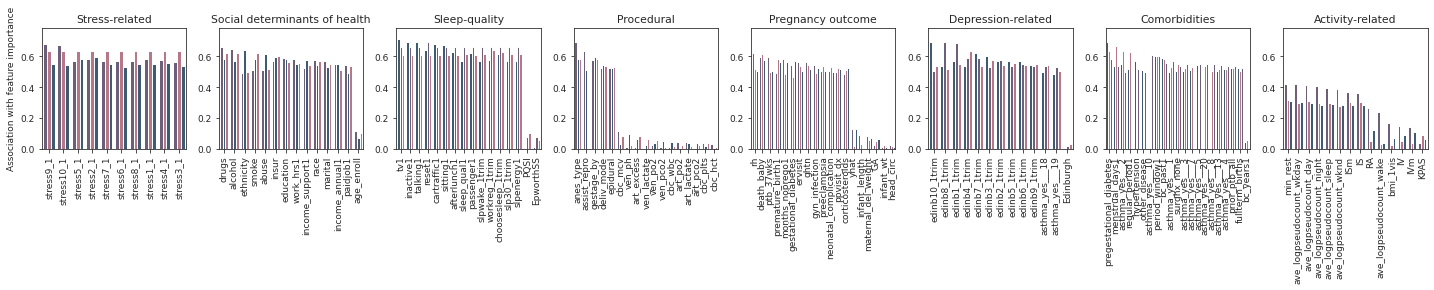

In [391]:
# wrangle df
dt = results_all['impcorr_group']
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt = dt.sort_values(by=['cat', 'value'], ascending=False)

# plot
dtt = dt.loc[dt['variable']!='all']
fig = plt.figure(figsize=(20, 4))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(1, 8, i+1)
    sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if i==0:
        ax.set_ylabel('Association with feature importance')
    else:
        ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_title(cat)
    ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
fig.tight_layout()

In [395]:
results_all['errcorr'].head()

,all,lt10wks,Higher-than-actual,Lower-than-actual
age_enroll,-0.007842,-0.073856,0.108551,0.141022
marital,0.449554,0.433249,0.579813,0.563403
gestage_by,0.71031,0.685841,0.595218,0.551625
insur,0.754853,0.679712,0.542309,0.563682
ethnicity,0.308057,0.350844,0.428788,0.490735


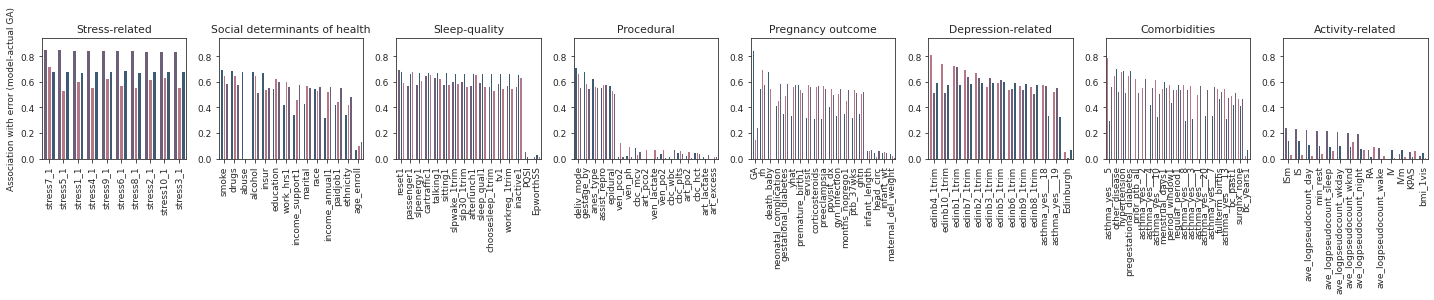

In [396]:
# wrangle df
dt = results_all['errcorr']
dt['cat'] = dt.index.map(md_node_annotation)
dt = dt.loc[~dt['cat'].isna()]
dt = dt.reset_index().melt(id_vars=['cat', 'index'])
dt['value'] = dt['value'].abs()
dt = dt.sort_values(by=['cat', 'value'], ascending=False)

# plot
dtt = dt.loc[dt['variable']!='all']
fig = plt.figure(figsize=(20, 4))
for i, cat in enumerate(dt['cat'].unique()):
    ax = fig.add_subplot(1, 8, i+1)
    sns.barplot(x='index', y='value', data=dtt.loc[(dtt['cat']==cat)], hue='variable', palette=grp_cmap, ax=ax)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if i==0:
        ax.set_ylabel('Association with error (model-actual GA)')
    else:
        ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_title(cat)
    ax.set_ylim([0, 0.1*np.max(dtt['value'])+np.max(dtt['value'])])
fig.tight_layout()

### plots for all, grouped by md var category

show all first with appropriate color panel, then go into details of interesting ones

In [271]:
# add category labels
from wearables.scripts.aesthetics import md_node_annotation, md_node_category_cmap

md_node_annotation['GA'] = 'Pregnancy outcome'
md_node_annotation['yhat'] = 'Pregnancy outcome'
df = errgrpcorr.abs()
df['cat'] = [md_node_annotation[i] for i in errgrpcorr.index]


In [272]:
color_groups = 'cat'
ranking_col = 'all'


In [273]:
grp_cmap = {
    'all': '#F67280',
    'Higher-than-actual': '#C06C84',
    'Lower-than-actual': '#6C5B7B',
    'lt10wks': '#355C7D',
}

In [274]:
savefigs = True

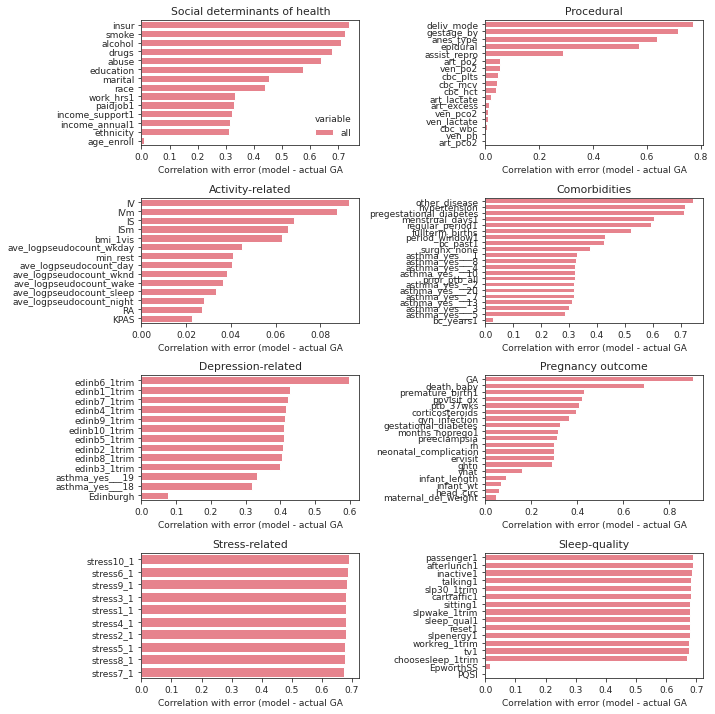

In [275]:
fig = plt.figure(figsize=(10, 10))
for i, c in enumerate(df[color_groups].unique()):
    ax = fig.add_subplot(4, 2, i+1)
    dt = df.loc[df[color_groups]==c, :].sort_values(by=ranking_col, ascending=False)
    dt = dt.reset_index().melt(id_vars=['index', color_groups])
    sns.barplot(x='value', y='index', hue='variable', data=dt, ax=ax, palette=grp_cmap)
    if i!=0:
        ax.legend().set_visible(False)
    ax.set_xlabel('Correlation with error (model - actual GA')
    ax.set_ylabel('')
    ax.set_title(f"{c}")
fig.tight_layout()
if savefigs:
    fig.savefig(os.path.join(pfp, 'barplots_groupedVarsVerrcorr.pdf'), bbox_inches='tight')

In [277]:
from scipy.stats import spearmanr 
spearmanr(md['PQSI'], md['error'])

SpearmanrResult(correlation=-0.0005323469692652612, pvalue=0.9789333200117816)

#### stats to manually draw

sleep yes/no in lt and gt grp

### method

z-test (https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html) and mwu to make point that this is more important... talk about the details in the results and write it

In [79]:
from scipy.stats import ttest_ind, mannwhitneyu

In [84]:
(a==0).sum() / len(a)

0.8669995432623455

In [85]:
(b==0).sum() / len(b)

0.016080526904436437

In [99]:
res_lt4wk

,attr,uid,sleep,t,morningVevening,weekdayVweekend,dayVnight,group,abs_attr
0,0.0,1720_16,1,2019-02-28 00:00:00,NA,Weekday,Night,lt4wk,0.0
1,0.0,1720_16,1,2019-02-28 00:01:00,NA,Weekday,Night,lt4wk,0.0
2,0.0,1720_16,1,2019-02-28 00:02:00,NA,Weekday,Night,lt4wk,0.0
3,0.0,1720_16,1,2019-02-28 00:03:00,NA,Weekday,Night,lt4wk,0.0
4,0.0,1720_16,1,2019-02-28 00:04:00,NA,Weekday,Night,lt4wk,0.0
...,...,...,...,...,...,...,...,...,...
10075,0.0,2557_8,1,2019-05-03 23:55:00,Evening,Weekday,Night,gt4wk,0.0
10076,0.0,2557_8,1,2019-05-03 23:56:00,Evening,Weekday,Night,gt4wk,0.0
10077,0.0,2557_8,1,2019-05-03 23:57:00,Evening,Weekday,Night,gt4wk,0.0
10078,0.0,2557_8,1,2019-05-03 23:58:00,Evening,Weekday,Night,gt4wk,0.0


In [80]:
a = res_lt4wk.loc[res_lt4wk['sleep']==1, 'abs_attr']
b = res_lt4wk.loc[res_lt4wk['sleep']==0, 'abs_attr']
ttest_ind(a, b, equal_var)

Ttest_indResult(statistic=-473.7548488398785, pvalue=0.0)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='abs_attr', ylabel='Density'>

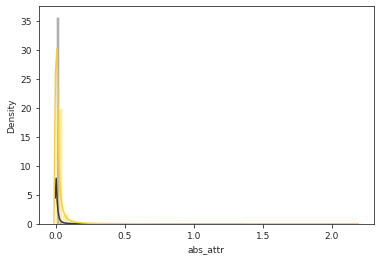

In [41]:
sns.histplot(res_lt4wk.loc[(res_lt2wk['sleep']==1, 'abs_attr'], color=sleep_cmap[1])
sns.distplot(res_lt2wk.loc[res_lt2wk['sleep']==0, 'abs_attr'], color=sleep_cmap[0])

# plot single examples

In [111]:
savefigs=True

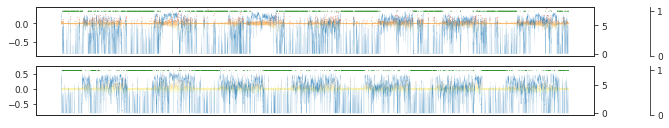

In [115]:
sleep = trainer.data.data['data'][uid_ptb]['sleep'][:-1]
sleep.replace(0, np.nan, inplace=True)
fig, ax = plt.subplots(2, 1, figsize=(10, 2)) 
ax[0].scatter(np.arange(x.shape[-1]), attr_ptb[0, 0, :].detach(), c=attr_ptb[0, 0, :].detach(), cmap='RdYlBu_r', s=0.5, rasterized=True, edgecolor='none')
par2 = ax[0].twinx()
par2.plot(np.arange(x.shape[-1]), x[0, 0, :].detach(), linewidth=0.1, alpha=0.75, rasterized=True)
# par2.set_ylabel('Activity (log pseudocounts)')
par3 = ax[0].twinx()
par3.set_ylim(0, 1.1)
par3.scatter(np.arange(x.shape[-1]), sleep, linewidth=0.1, color='green', s=0.1, rasterized=True, edgecolor='none')
par3.spines.right.set_position(("axes", 1.1))
ax[0].set_xticks([])

sleep_noptb = trainer.data.data['data'][uid_noptb]['sleep'][:-1]
sleep_noptb.replace(0, np.nan, inplace=True)
ax[1].scatter(np.arange(x.shape[-1]), attr_noptb[0, 0, :].detach(), c=attr_noptb[0, 0, :].detach(), cmap='RdYlBu_r', s=0.5, rasterized=True, edgecolor='none')
par2 = ax[1].twinx()
par2.plot(np.arange(x.shape[-1]), x_noptb[0, 0, :].detach(), linewidth=0.1, alpha=0.75, rasterized=True)
# par2.set_ylabel('Activity (log pseudocounts)')
par3 = ax[1].twinx()
par3.set_ylim(0, 1.1)
par3.scatter(np.arange(x.shape[-1]), sleep_noptb, linewidth=0.1, color='green', s=0.1, rasterized=True, edgecolor='none')
par3.spines.right.set_position(("axes", 1.1))
ax[1].set_xticks([])

if savefigs:
    fig.savefig('/home/ngrav/project/wearables/results/ptbVnoptb_pathexpattr.png', bbox_inches='tight', dpi=600)

In [132]:
df_sleep = pd.DataFrame({'sleep': sleep.replace(np.nan, 0).to_list(), 'importance': attr_ptb[0, 0, :].detach().numpy(), 'md':['ptb']*sleep.shape[0]})
dt = pd.DataFrame({'sleep': sleep_noptb.replace(np.nan, 0).to_list(), 'importance': attr_noptb[0, 0, :].detach().numpy(), 'md':['noptb']*sleep_noptb.shape[0]})
df_sleep = df_sleep.append(dt)
del dt

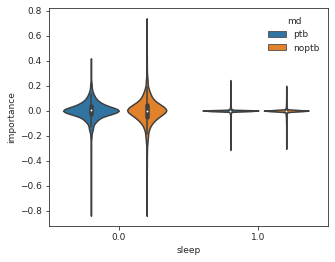

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.violinplot(x='sleep', y='importance', hue='md', data=df_sleep, ax=ax)
# sns.swarmplot(x='sleep', y='importance', hue='md', data=df_sleep, ax=ax)
if savefigs:
    fig.savefig('/home/ngrav/project/wearables/results/violin_ptbVnoptb_bysleep_pathexpattr.png', bbox_inches='tight', dpi=600)

# correlations with error

show corr net, only significant ones can retain edge

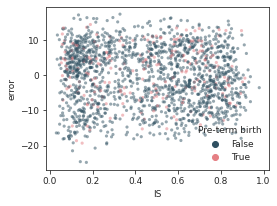

In [45]:
ptb_cmap = {False: '#2F5061', True: '#E57F84'}
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='IS', y='error', data=md.loc[md['split']=='train'], hue='Pre-term birth',
                palette=ptb_cmap, linewidth=0, s=10, alpha=0.5, rasterized=True, ax=ax)
fig.savefig(os.path.join(pfp, 'scatter_errorVIS_train.pdf'), bbox_inches='tight')

## mask or stratify by feature importance